# 0.0 Imports

In [1]:
import math
import pandas as pd
import random
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import random
import pickle
import warnings


from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML


from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold +1 )):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] >= validation_end_date)]

        # training and validation dataset
        # training 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # dataframe
    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2 ).astype(str) + ' +/- ' + np.round(np.std(mae_list),2 ).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2 ).astype(str) + ' +/- ' + np.round(np.std(mape_list),2 ).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2 ).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2 ).astype(str)}, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( ( y - yhat )/ y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0] )

def cramer_v( x, y ):
    # tabela de contigencia/ matriz de confusão dos meus dados categoricos
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    # correção de vies
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
# low_memory = False (ler todo o arquivo na mesma hora coloca na memoria)
df_sales_raw = pd.read_csv ('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [ ]:
df_sales_raw.head()

In [ ]:
df_store_raw.head()

In [ ]:
df_raw.sample()

# 1.0 DESCRICAO DOS DADOS

In [5]:
# é sempre bom em cada sessão fazer uma copy do dataframe
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2  Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
# mudar o types da coluna date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance - distancia em metros da loja competidora proxima
    # uma das formas de eliminar os NAs é preenchendo as linhas faltantes
    # utilizando a lógica de que talvez  NA é pq a loja competidora está bem distante
    # e para isso irei preencher um valor qualquer 200000.0 (maior q o valor maximo do meu dataframe) 
    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month - mes/ano que a loja competidora foi aberta
    # quando é mais de uma coluna coloca axis=1
    
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month 
                                               if math.isnan(x['competition_open_since_month']) else 
                                               x['competition_open_since_month'], axis=1)

#competition_open_since_year  
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['competition_open_since_year']) else      
                                               x['competition_open_since_year'], axis=1)                       
#promo2_since_week
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week 
                                               if math.isnan(x['promo2_since_week']) else      
                                               x['promo2_since_week'], axis=1)  
#promo2_since_year   
df1['promo2_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['promo2_since_year']) else      
                                               x['promo2_since_year'], axis=1)
#promo_interval - intervalos consecutivos quando a promo2 foi iniciada
# dicionario indicando o numero dos meses
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sept',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
    # assumption: criadno uma coluna onde indica o mes da coluna date     
df1['month_map'] = df1['date'].dt.month.map(month_map)

    # assumption: se o mes estiver presente na coluna 'promo_interval' logo tem promocao ativa naquela data 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 
                                                            1 if x['month_map'] in x['promo_interval'].split(',') 
                                                            else 0, axis=1)

In [ ]:
df1.sample(2)

## 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
                  
# cocantenação dos dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

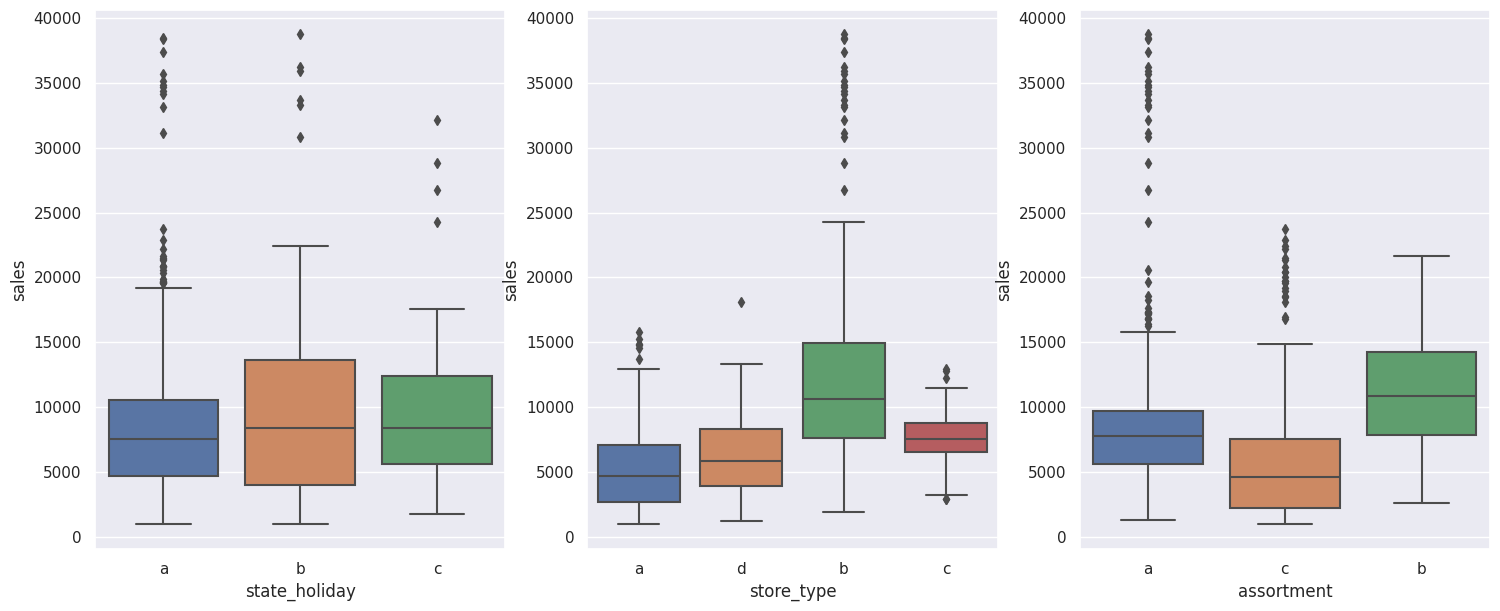

In [15]:
plt.figure(figsize=(18,7))
# filtrar o dataset
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux)

# 2.0 - Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
## extraindo novas features da coluna date
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

## features de competition
# competition since - juntas o mes - ano
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

## feature de promo
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# transformando em datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

## feature assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

# 3.0 - Filtragem das Variáveis

FILTRAGEM
**Restrições de acordo com o negócio**

SELEÇÃO
**Variáveis mais relevantes para o modelo desejado.**

In [18]:
df3 = df2.copy()

In [19]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 - Filtragem das linhas

In [20]:
# as restrições observadas para o negócio foram loja fechada e vendas nulas
df3 = df3[(df3['open'] != 0) & (df3['sales'] != 0 )]

## 3.2 - Seleção

In [21]:
# a coluna customers é uma restrição para o modelo, pois tem essa informação daqui 6 semanas
# a não ser que eu faça outro modelo de previsão para calcular a coluna customers daqui 6 semanas.
# então por isso, foi retirar essa coluna do meu dataset para fazer a predição de vendas daqui 6 semanas.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [ ]:
df3.columns

# 4.0 Análise Exploratória de Dados - EDA

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

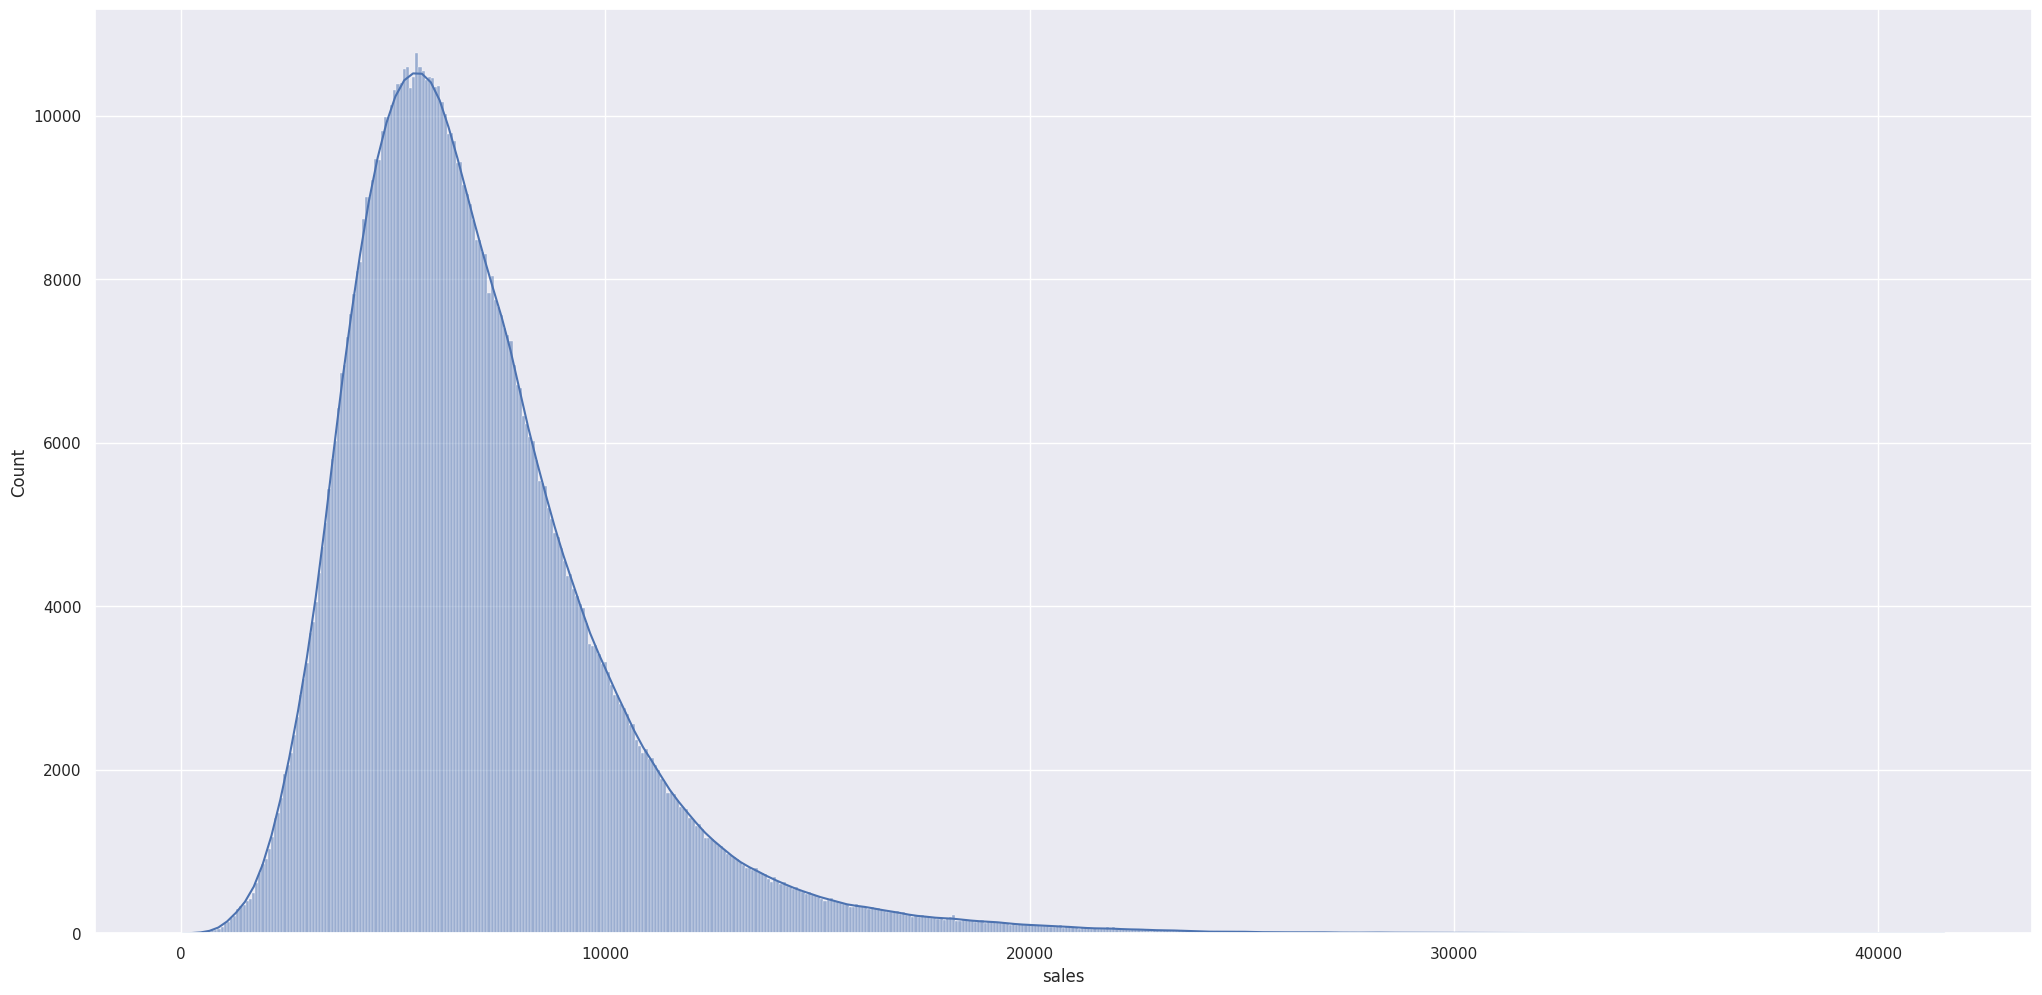

In [23]:
# a minha variavel resposavel pelo fenomeno é a coluna 'sales'
sns.histplot(df4['sales'], kde=True);
# kurtosis e skew? analisar

### 4.1.2 Numerical Variable

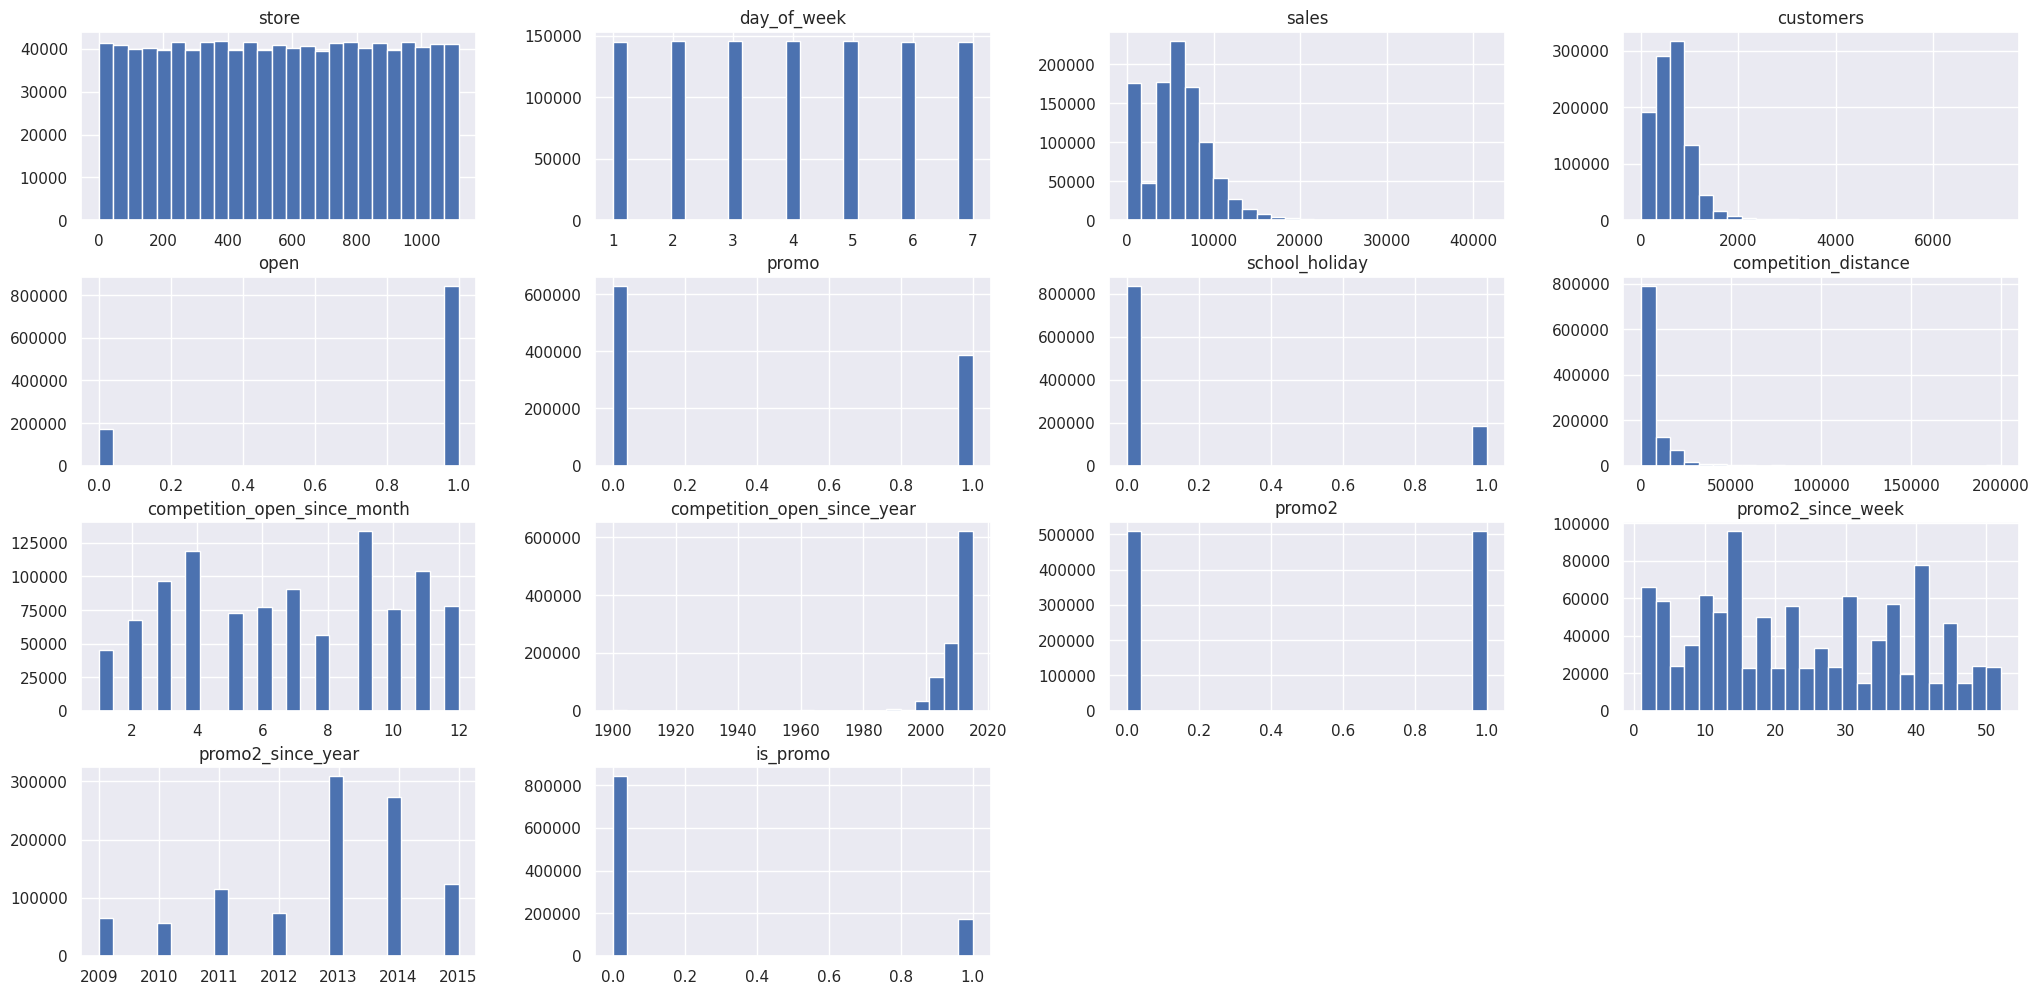

In [25]:

num_attributes.hist(bins=25);

### 4.1.2 Categorical Variable

In [26]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

<AxesSubplot: xlabel='sales', ylabel='Density'>

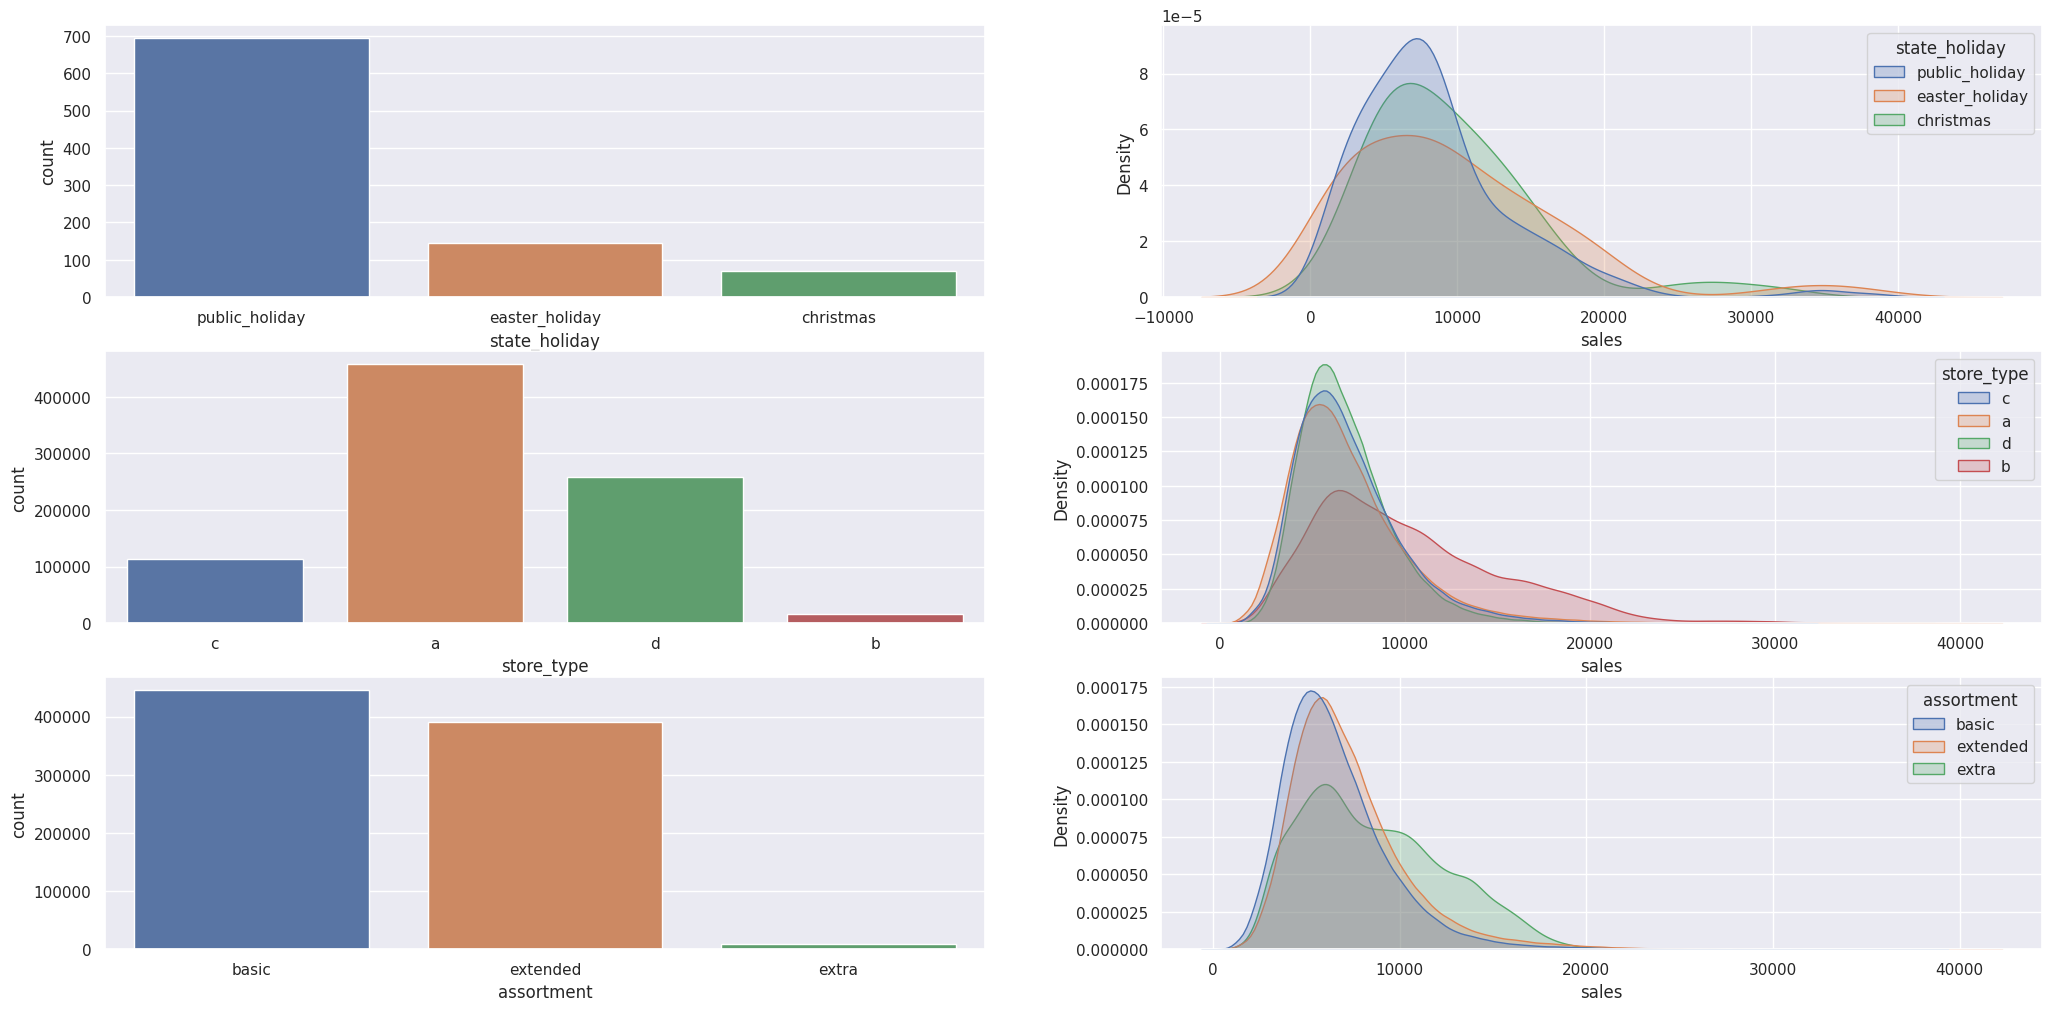

In [27]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x= a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(data=a, x='sales',hue='state_holiday', fill=True, common_norm=False)


# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, common_norm=False)
# sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], legend='a', fill=True )
# sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], legend='b', fill=True )
# sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], legend='c', fill=True )
# sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], legend='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, common_norm=False)
# sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], legend='extended', fill=True )
# sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], legend='basic',fill=True )
# sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], legend='extra',fill=True )

## 4.2 Análise Bivariada

In [28]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [29]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


#### **H1. Lojas com maior sortimentos deveriam vender mais.**
**FALSA** Lojas com MENOR sortimento vende mais.

<AxesSubplot: xlabel='year_week'>

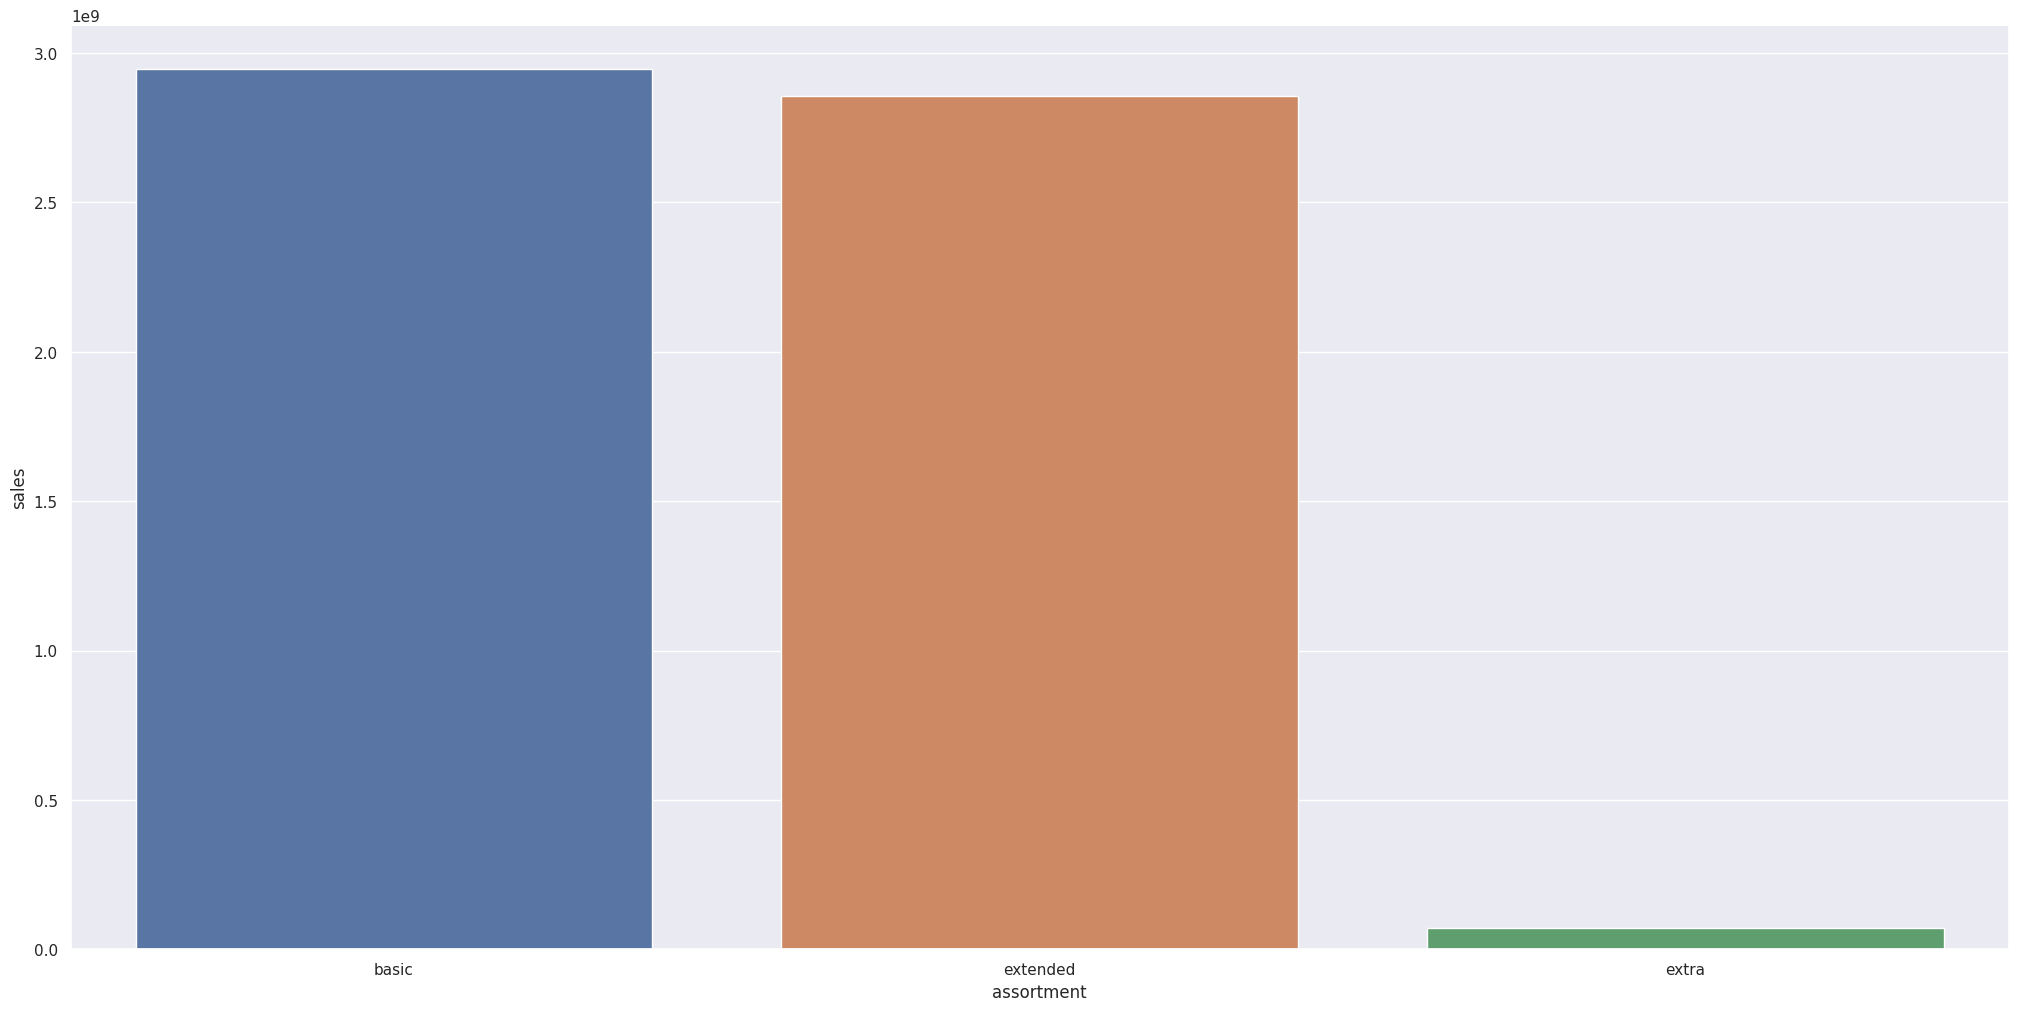

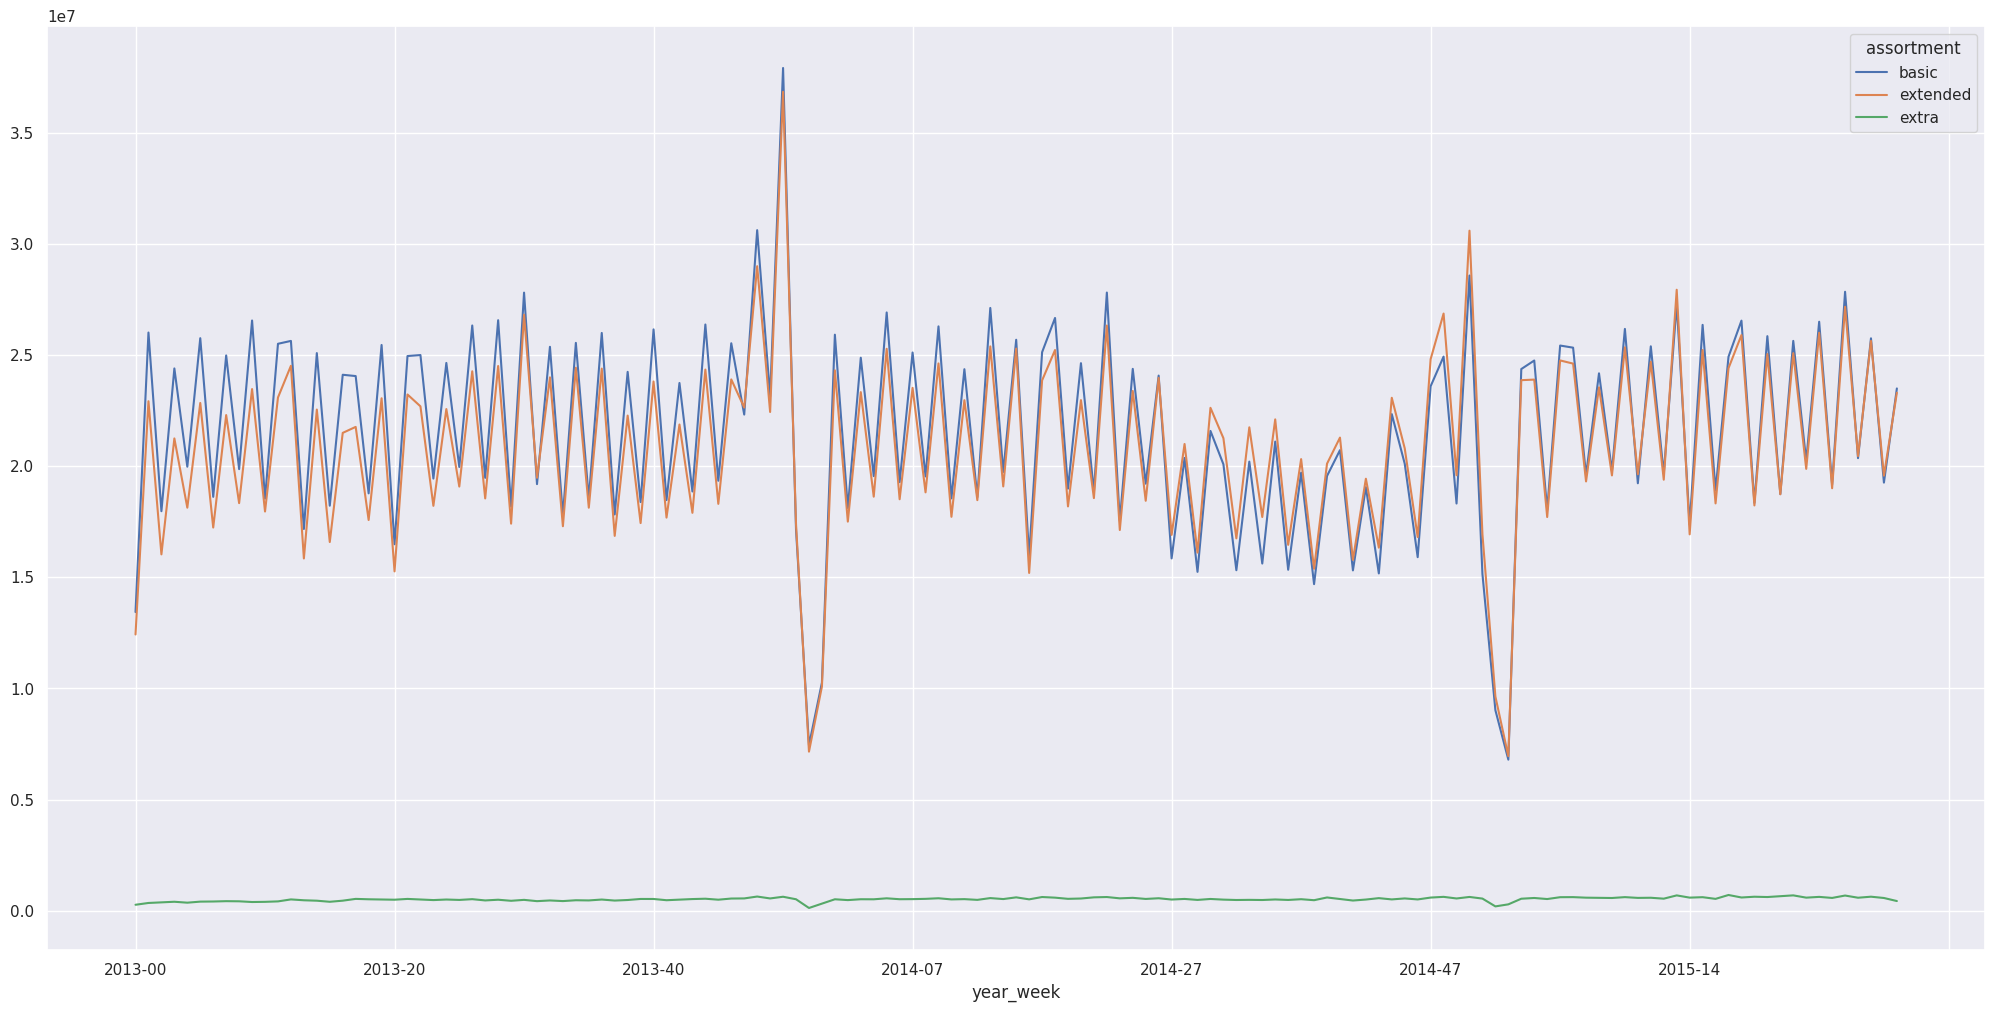

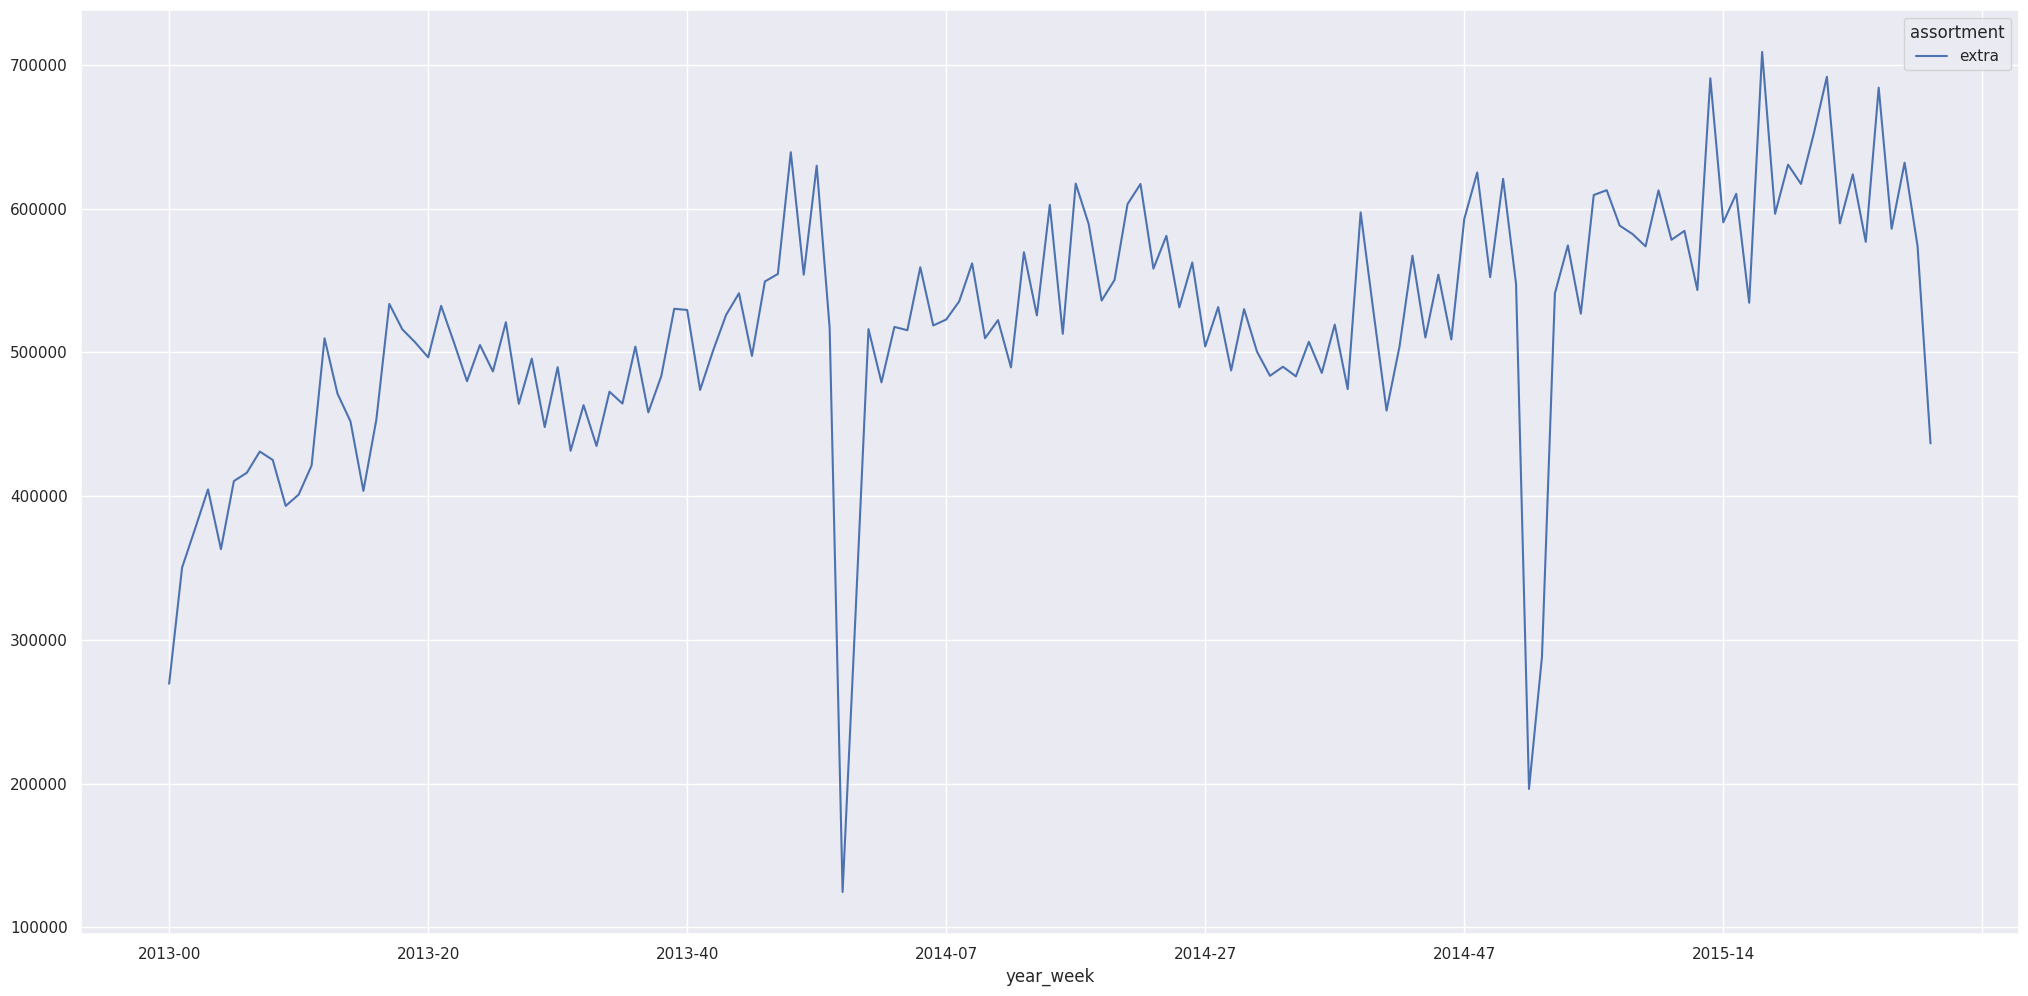

In [30]:
# para validar a hipotese é coloco o somatório de venda de cada sortemento 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# preciso coonfirmar isso ao longo do tempo
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# observando apenas as oscilações de venda ao longo do tempo do assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2. Lojas com competidores mais próximos deveriam vender menos.**
**FALSA** Lojas com competidores mais próximos vendem MAIS.

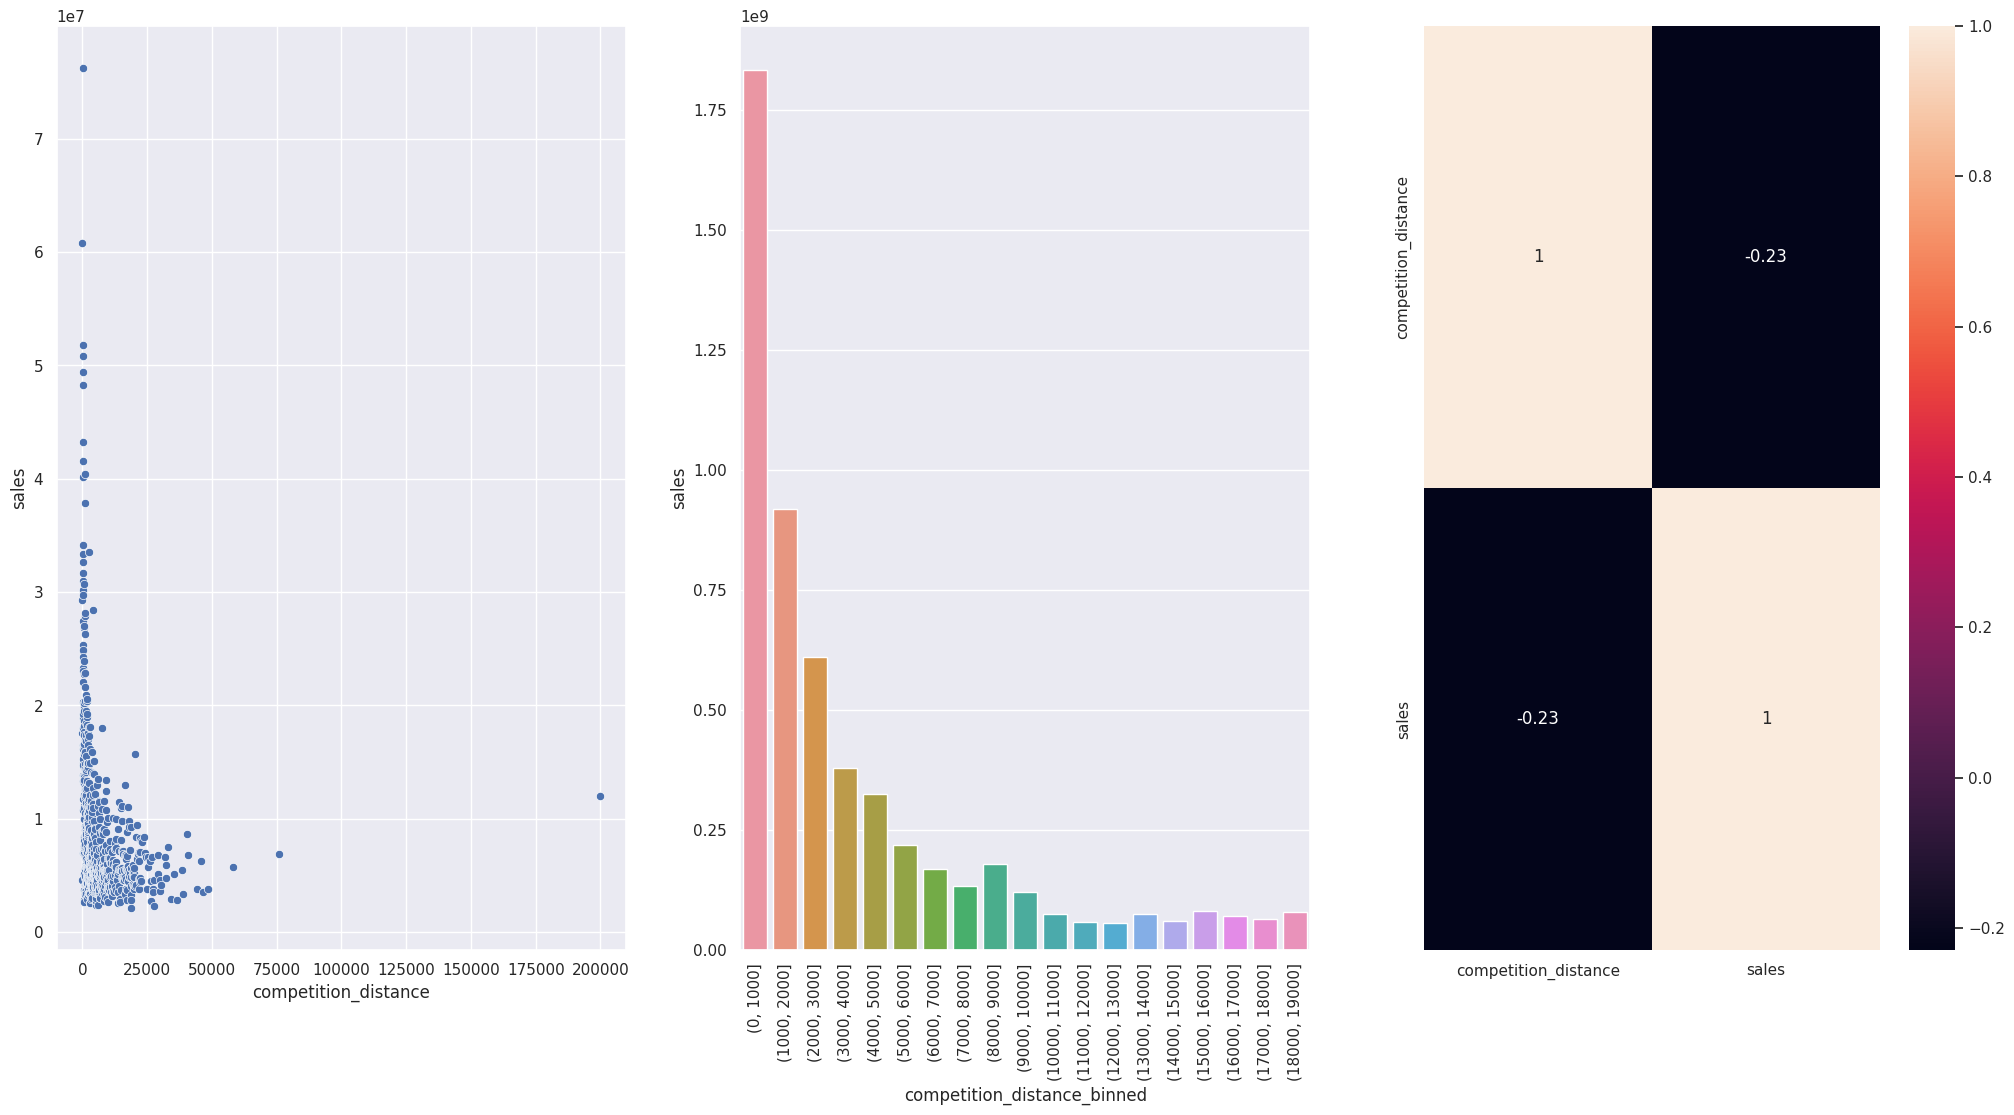

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
# bins seria a minha repartição em grupo da distancia de cada competidor
bins = list( np.arange(0,20000, 1000) )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**
**FALSA** Lojas com competidores recentes vendem MAIS

<AxesSubplot: >

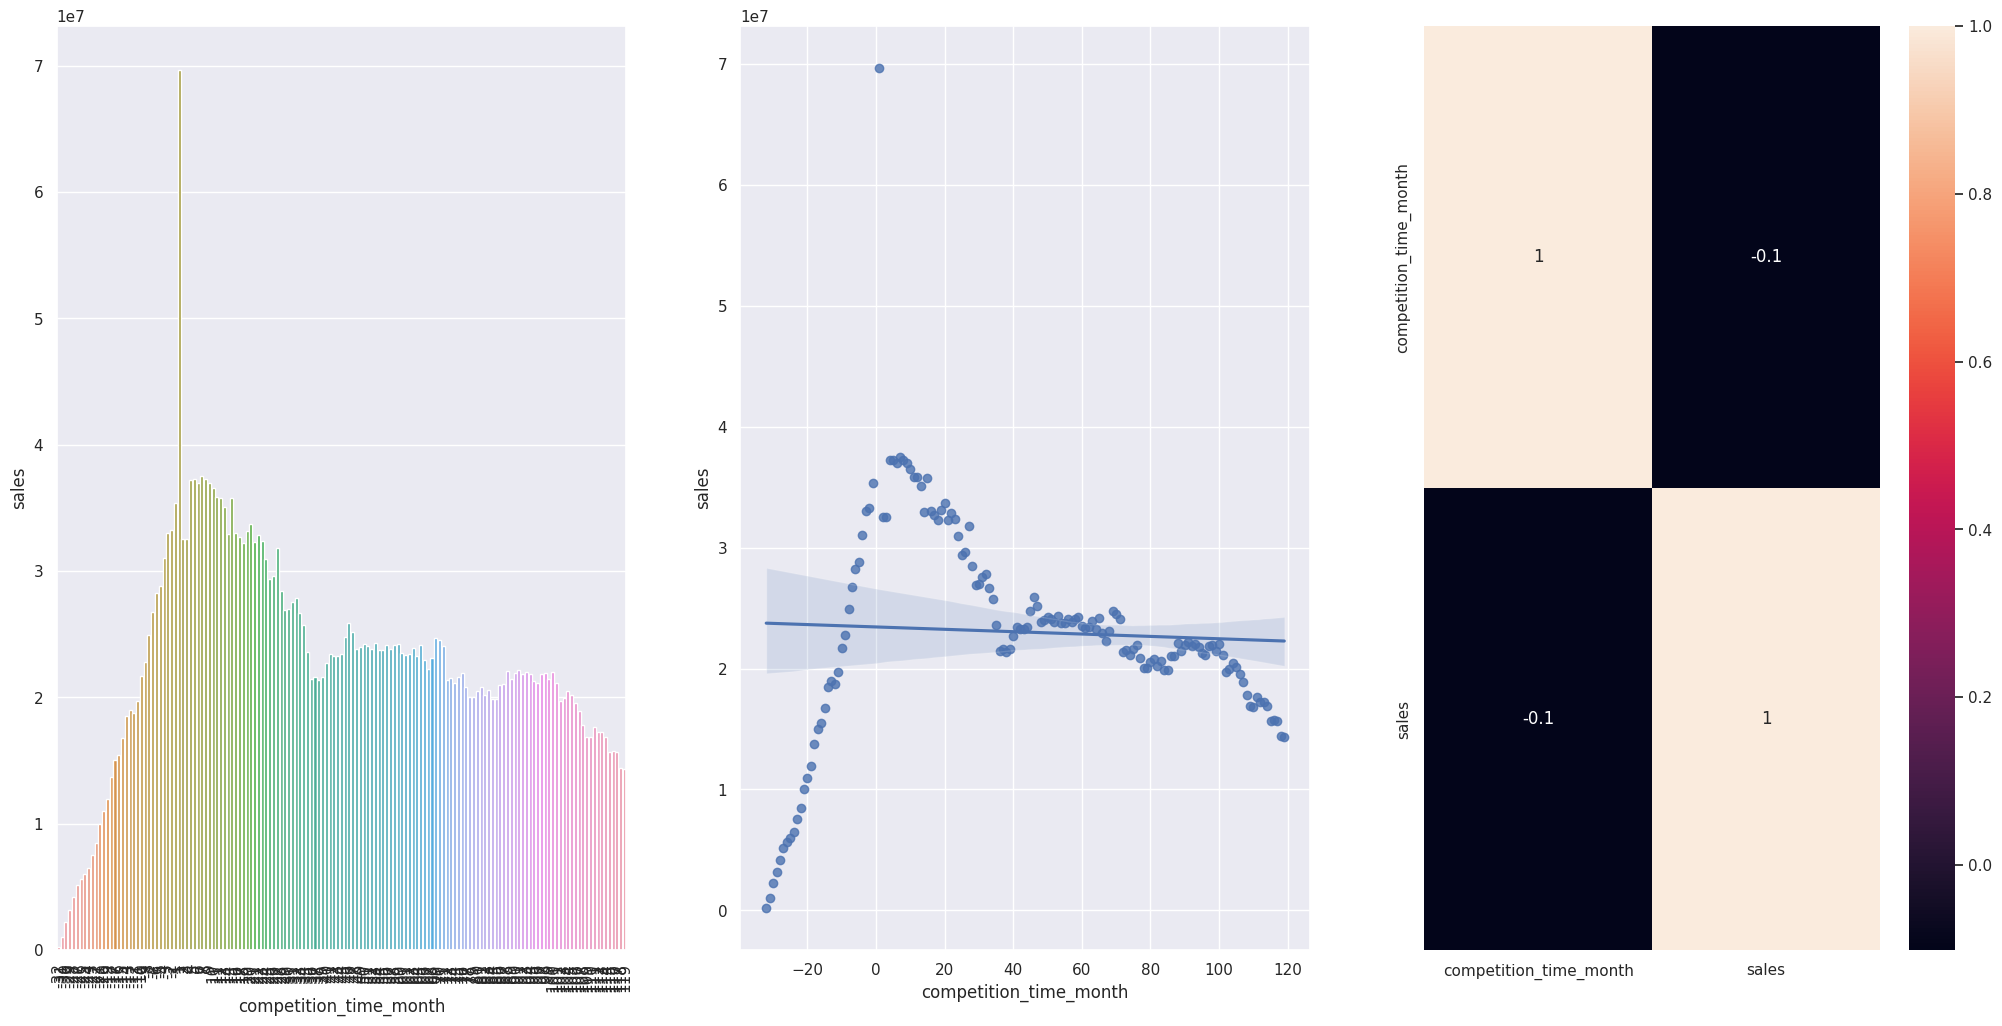

In [32]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data= aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.


In [ ]:
## ASSUPTION: quando o valor no promo_time_week for negativo significa que a venda daquele dia ocorreu na promoção tradicional 
# e não na promoção extendida
# o feature promo_time_week foi montado com a date da venda - a ativação da promoção extendida

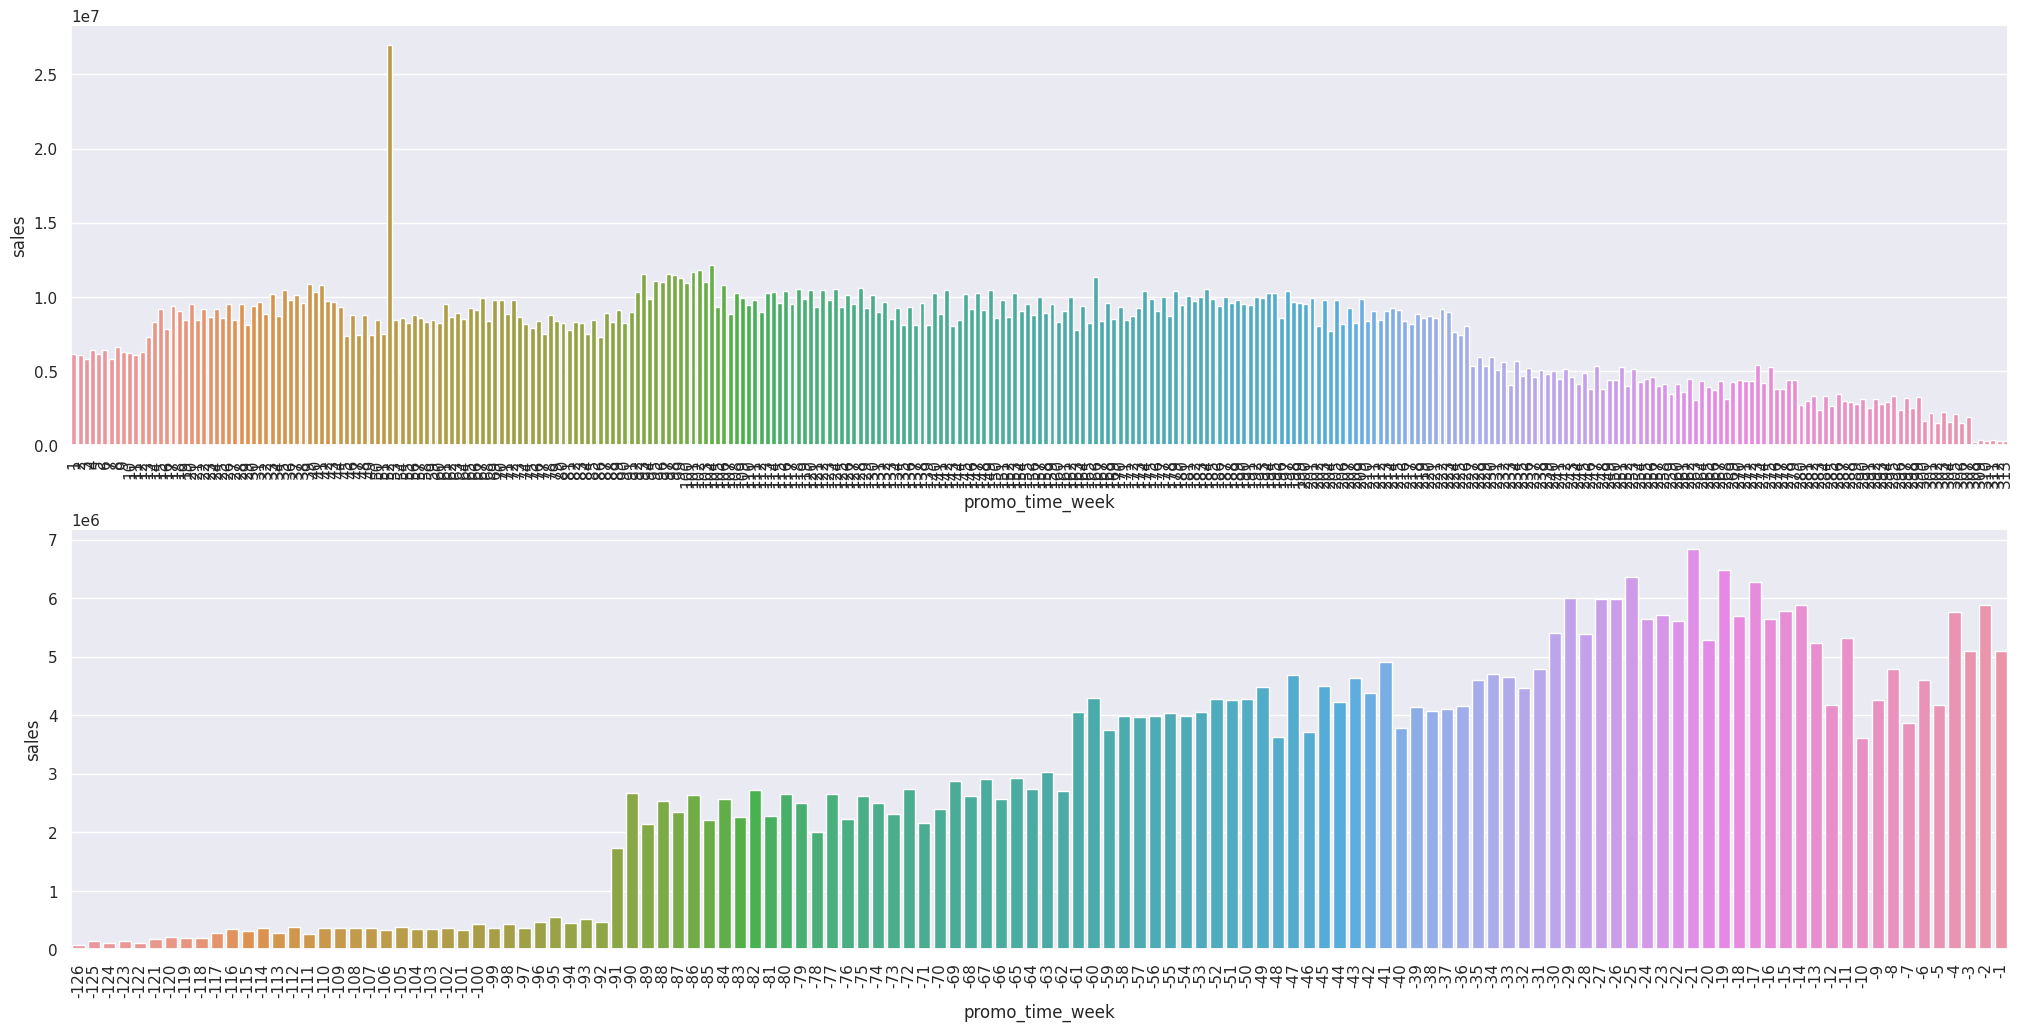

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# plot do somatorio das vendas na promo extendida
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= aux2)
plt.xticks(rotation=90);

# plot do somatorio das vendas na promo regular
plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= aux3)
plt.xticks(rotation=90);


Observações:
 * Gráfico 1: durante a promo extendida, podemos observar que durante um periodo ela se mantem com o seu somatorio de vendas regular. Depois de um periodo de tempo ocorre um decaimento.
 
 * Gráfico 2: Na promo tradicional, no seu inicio o somatorio de vendas é menor, aumentando conforme vai se aproximando a promo extendida. Podemos deduzir que pode ser o efeito de marketing para a promo extendida, ocasionando o aumento de vendas. 

In [ ]:
# confirmar a tendencia dos graficos
# tendencia da promo extendida
plt.subplot(1,2,1)
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

# tendecia da promo tradicional/regular
plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

Observação:

    - Grafico 1 - tendencia de queda na promo extendida ao longo do tempo
    - Grafico 2 - tendencia de subida na promo tradicional ao longo do tempo

In [ ]:
# observando a correlação através do heatmap
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Heatmap: corelação muito baixa -0,029 com as vendas. 

Logo, essa feature pode ter uma baixa relevancia para o modelo de predição de vendas.

#### <s>**H5. Lojas com mais dias de promoção deveriam vender mais.**</s>
Deixa para o próximo ciclo do CRISP - tal validação de hipotese deve criar mais uma feature de tempo em dias da promoção.


#### **H6. Lojas com mais promoções consecutivas deveriam vender mais.**
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [34]:
# agrupando o somatorio de vendas durante a promo e a promo2(consecutiva)
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=True)


,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


Observação da tabela:
* a maior quantidade de vendas foi apenas quando há promo. 
* a promo2 (consecuutiva) não é o maior valor de vendas

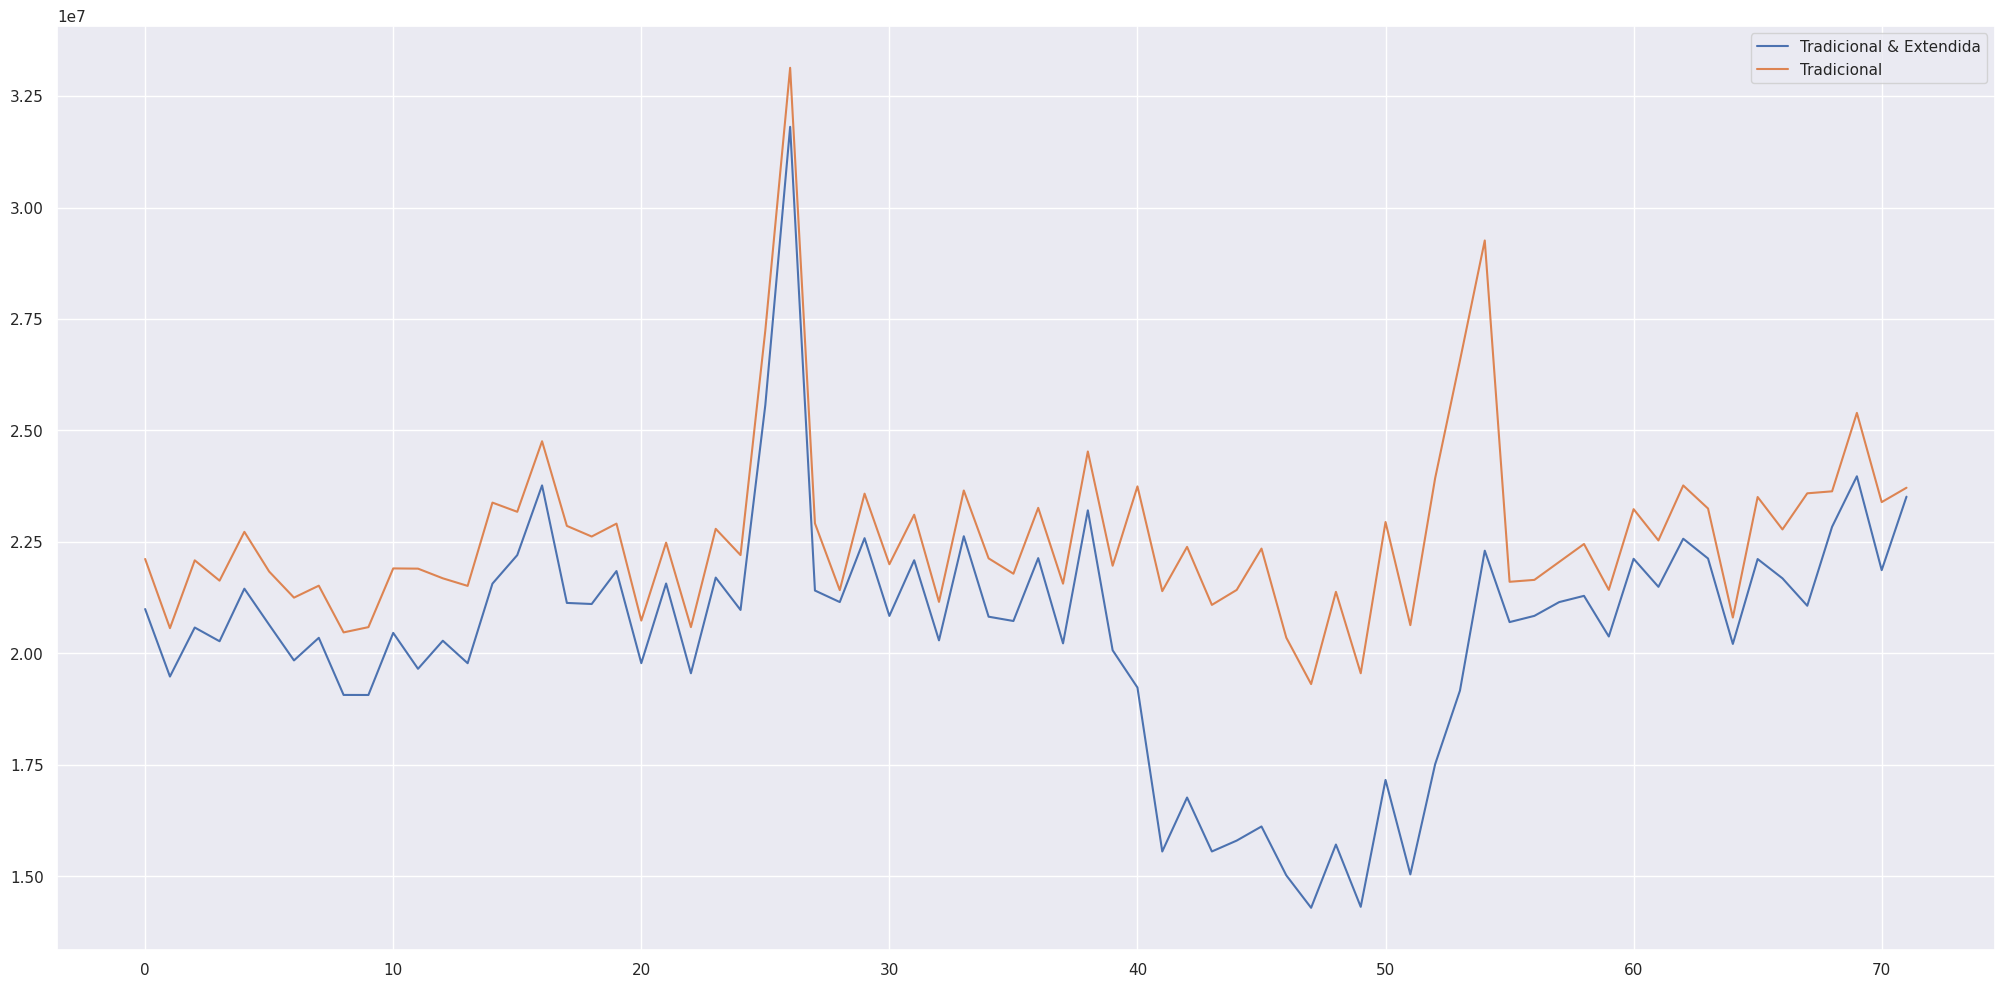

In [35]:
# observando ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);


#### **H7. Lojas abertas durante o feriado de Natal deveriam vender mais.**
**FALSA** 

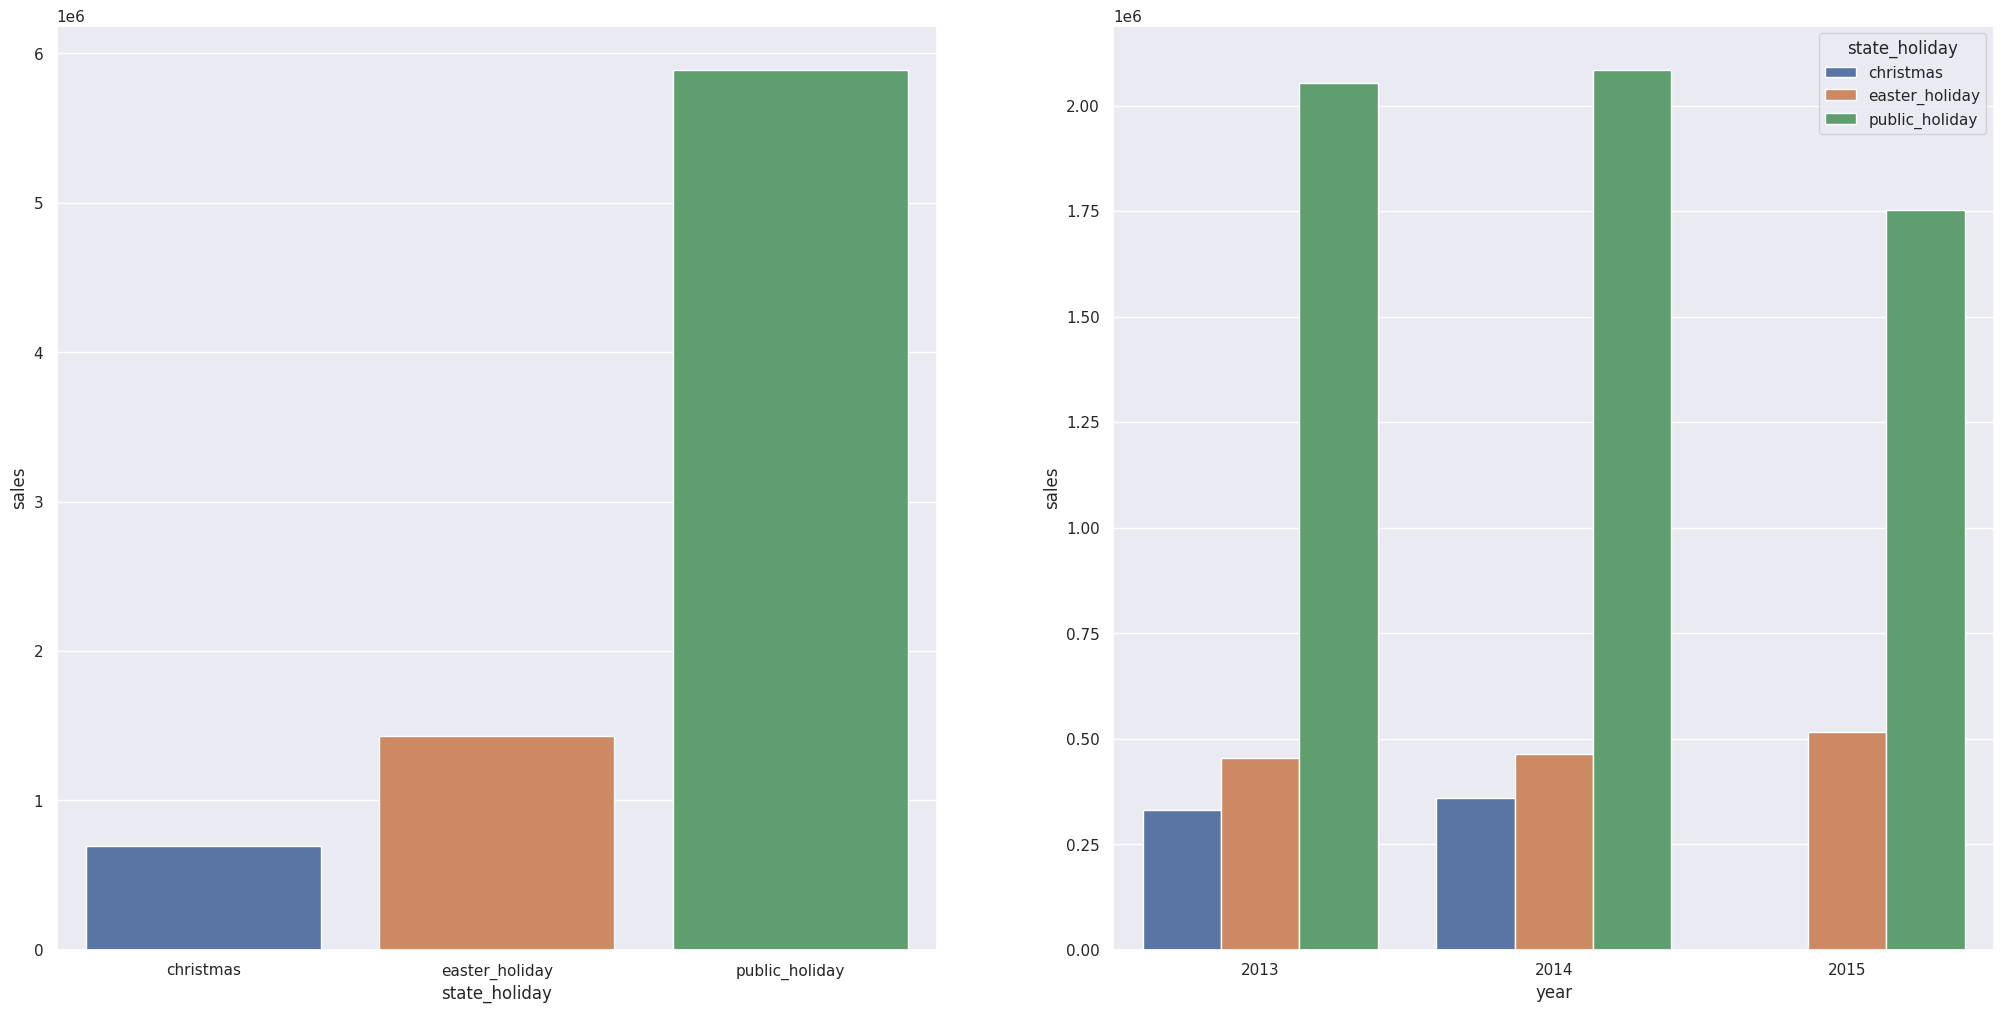

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8. Lojas deveriam vender mais ao longo dos anos.**
**FALSA** Lojas vendem ao longo dos anos

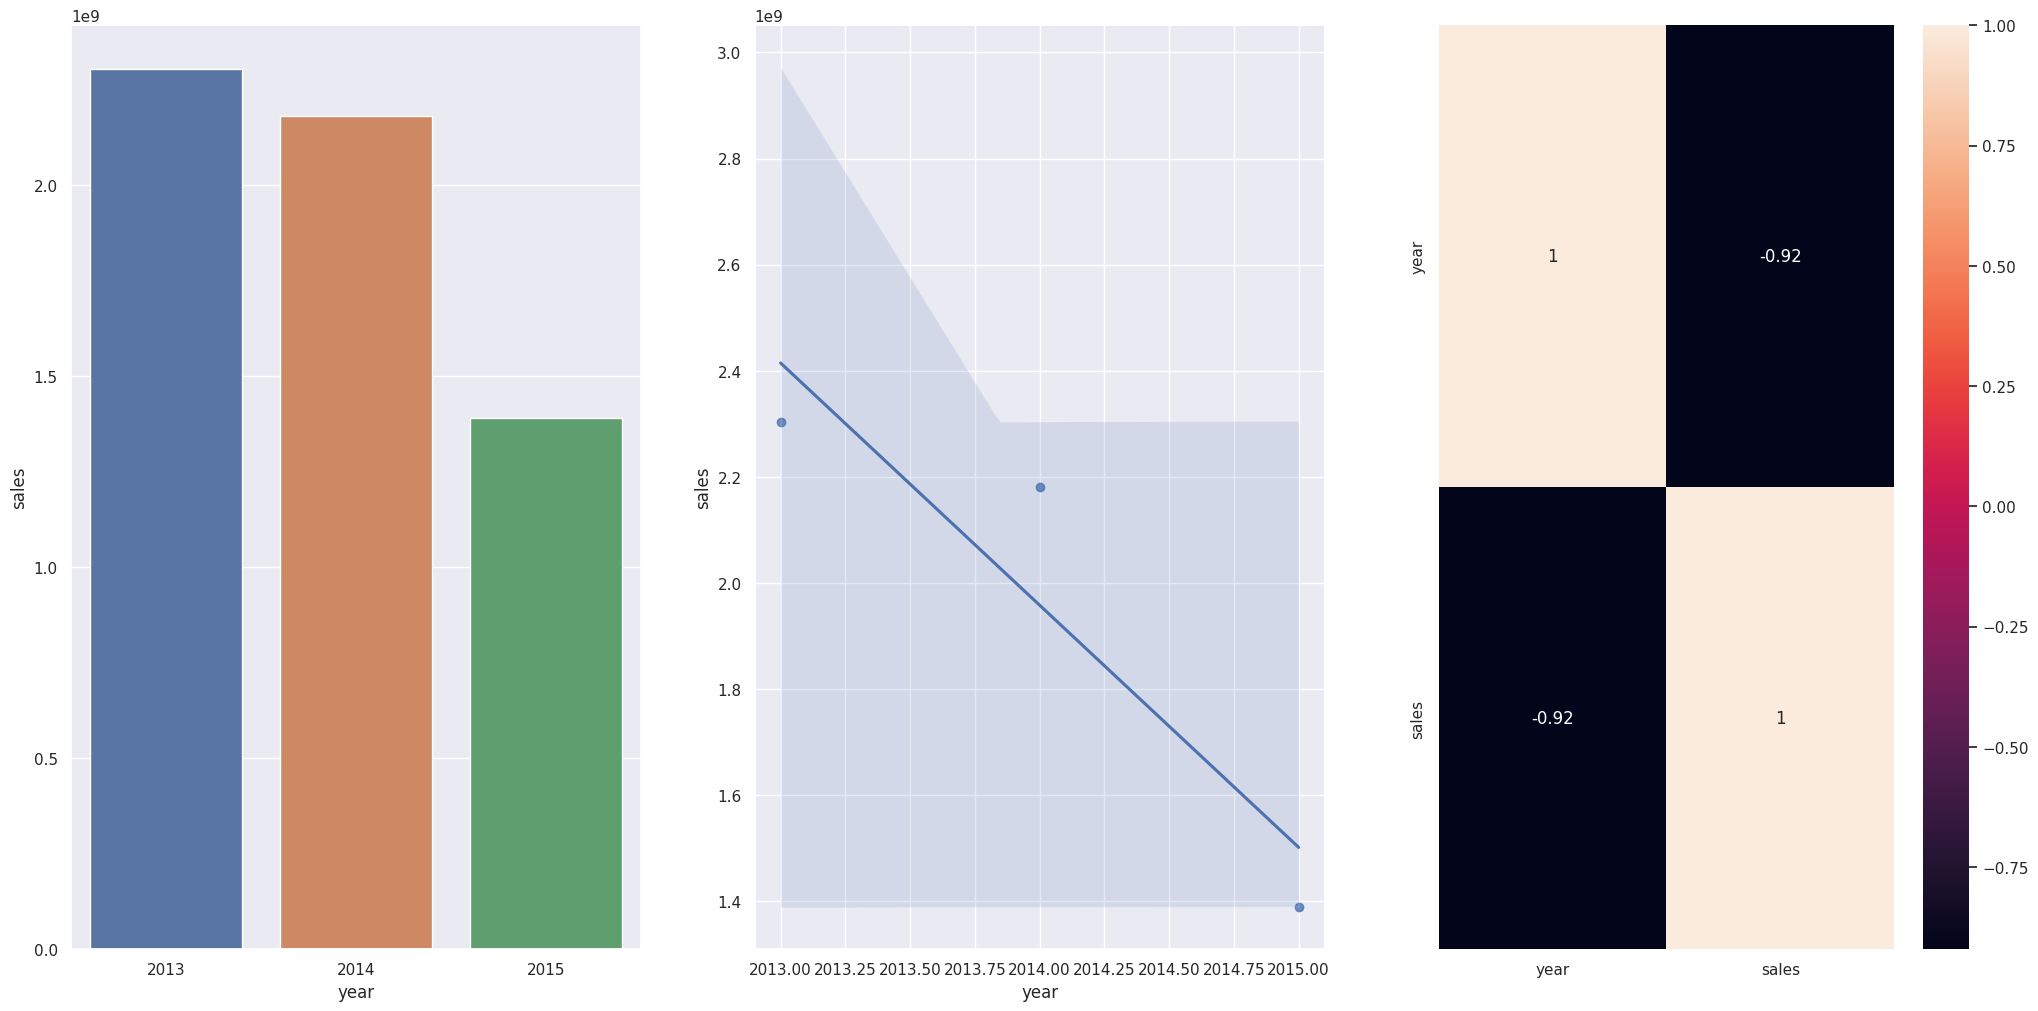

In [37]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H9. Lojas deveriam vender mais no segundo semestre do ano.**
**FALSA** Vendem menos no segundo semestre.

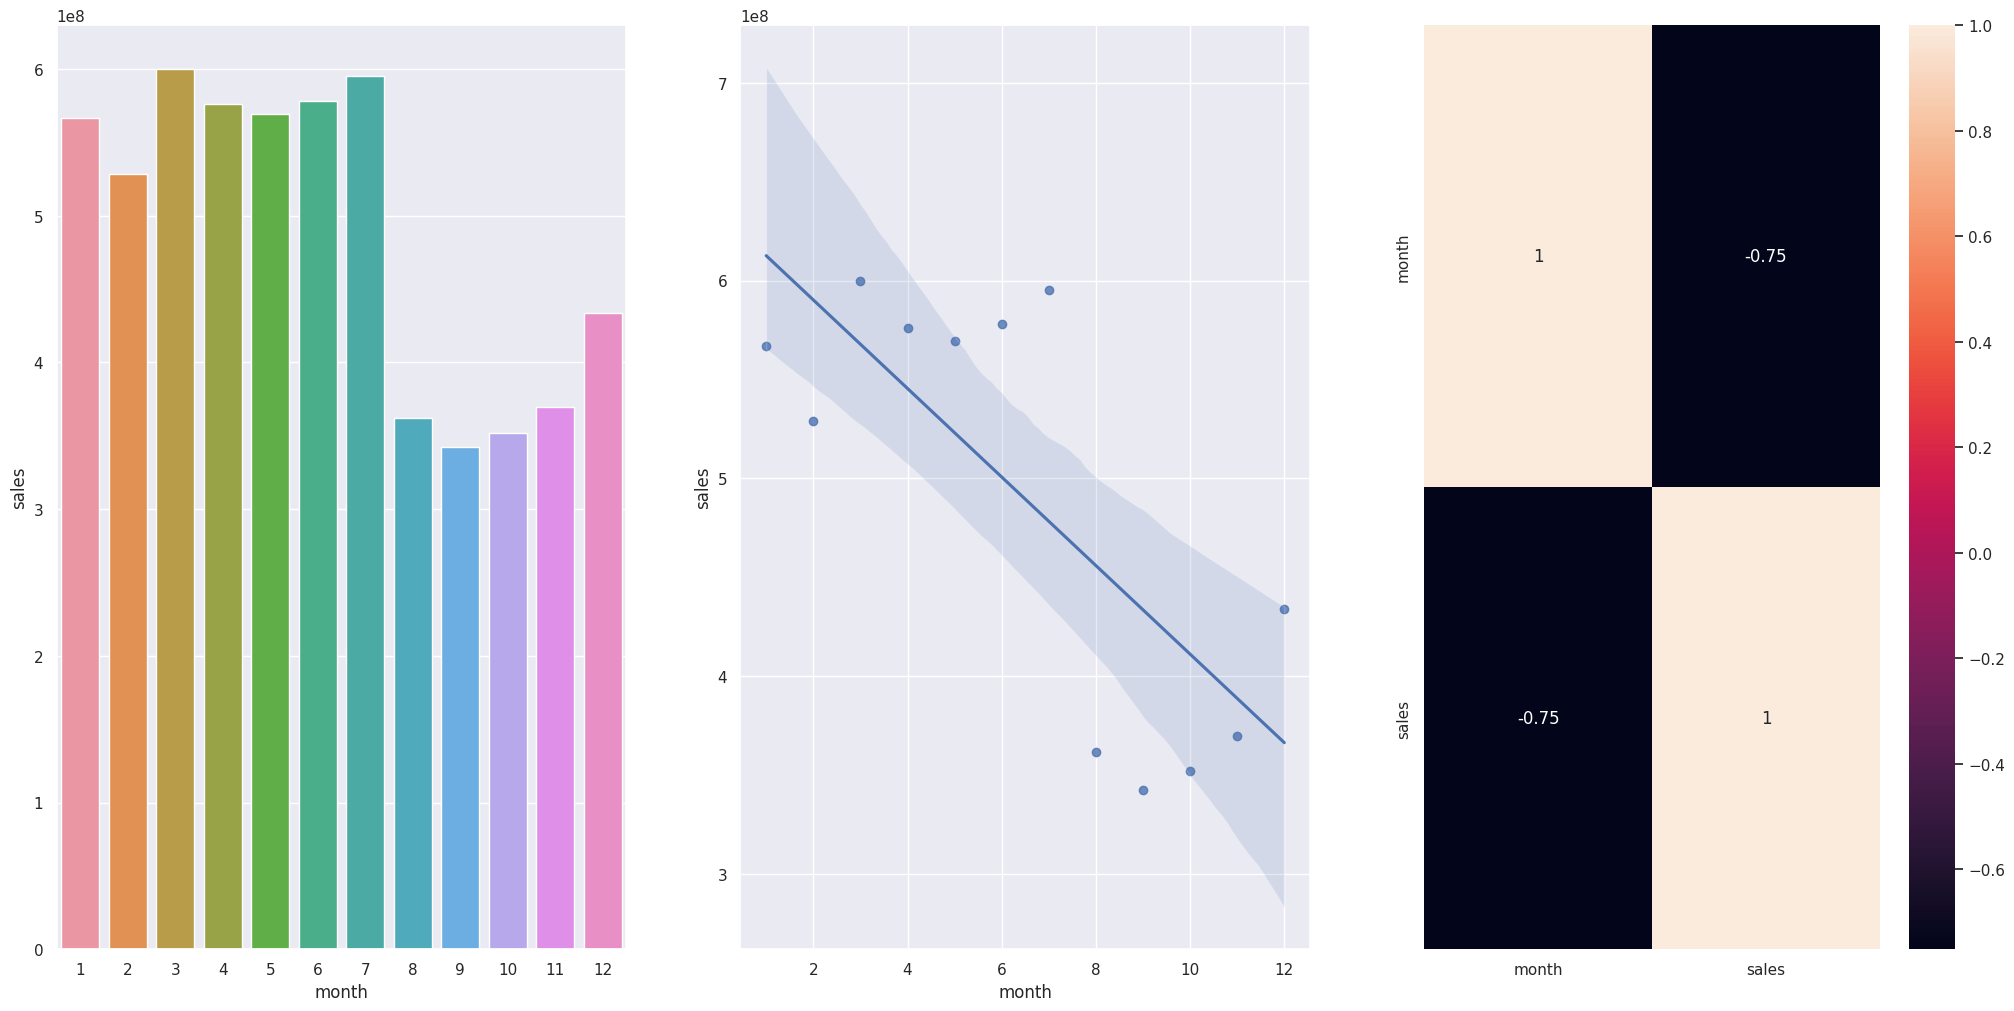

In [38]:
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Observação:
* No segundo semestre ocorre um decaimento.

#### **H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**
**VERDADEIRO**

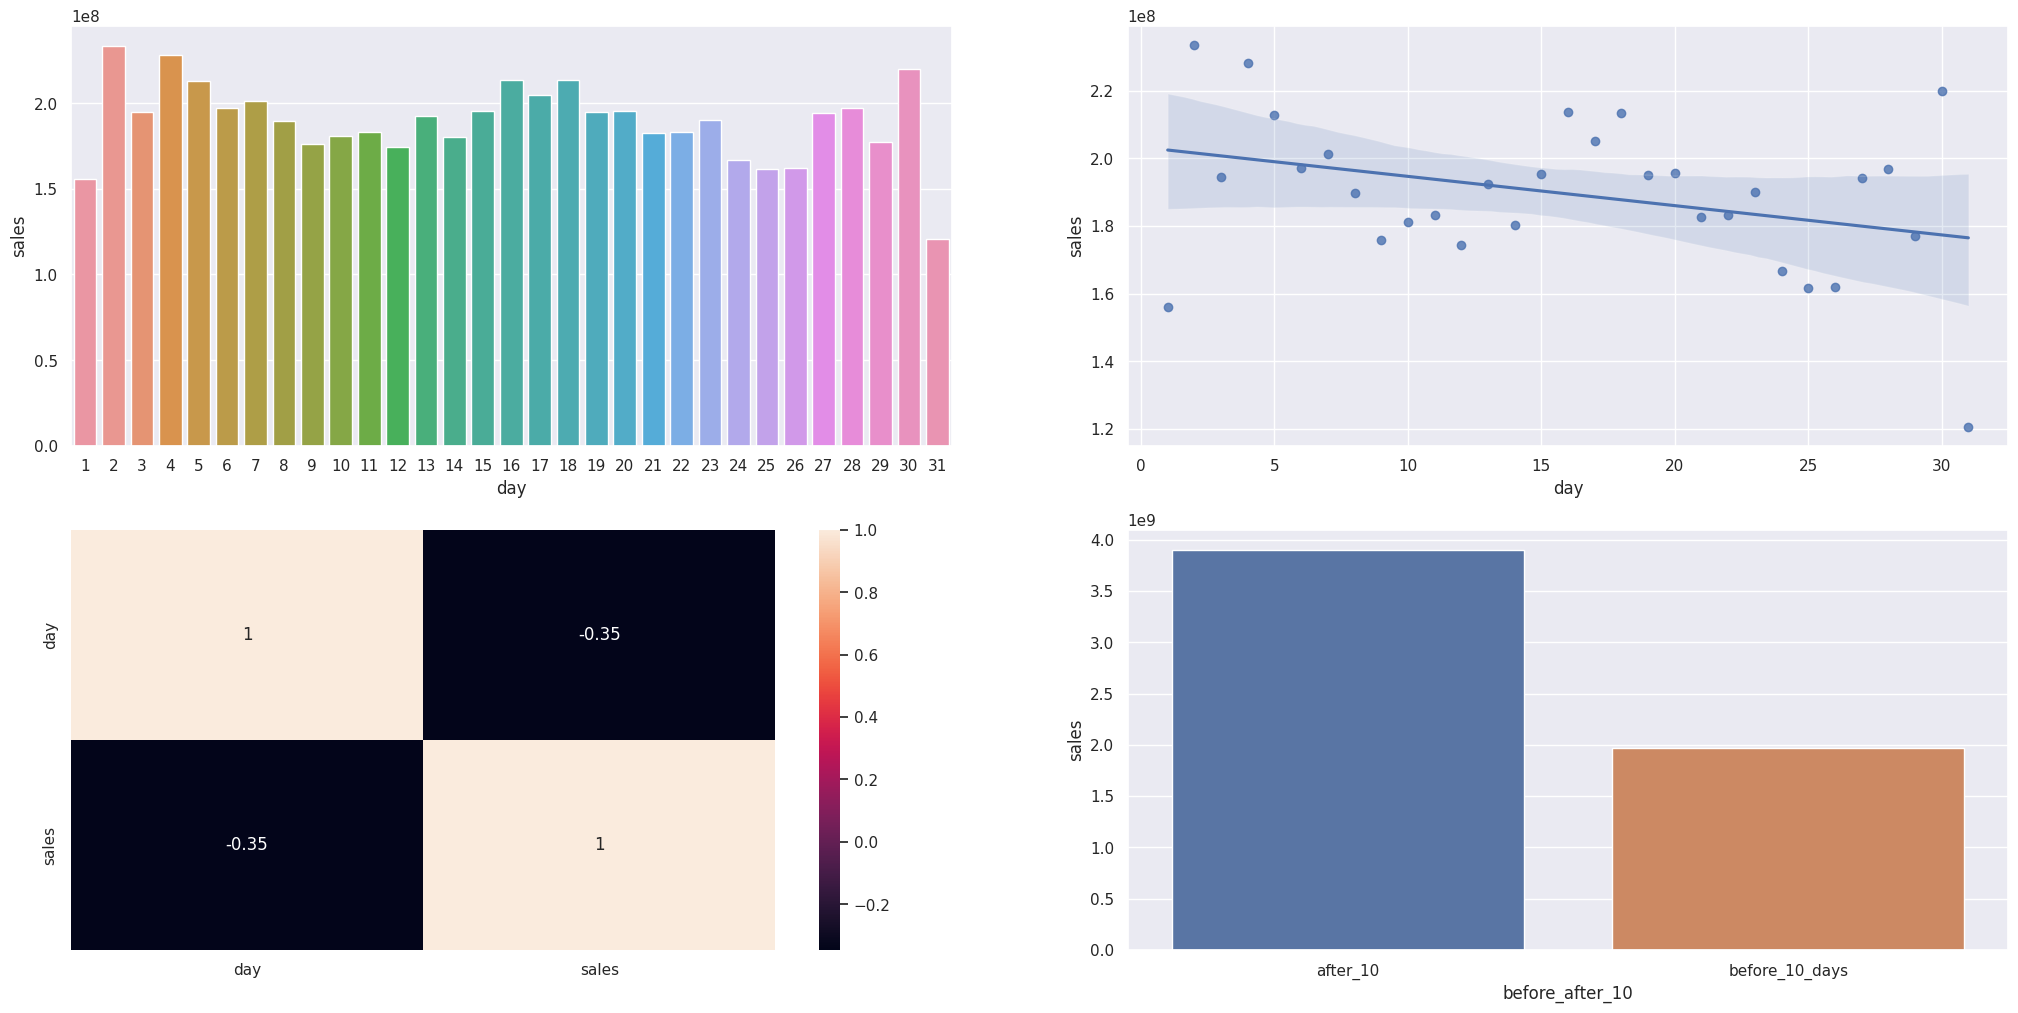

In [39]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2);

#### **H11. Lojas deveriam vender menos aos finais de semana.**
**VERDADEIRO**

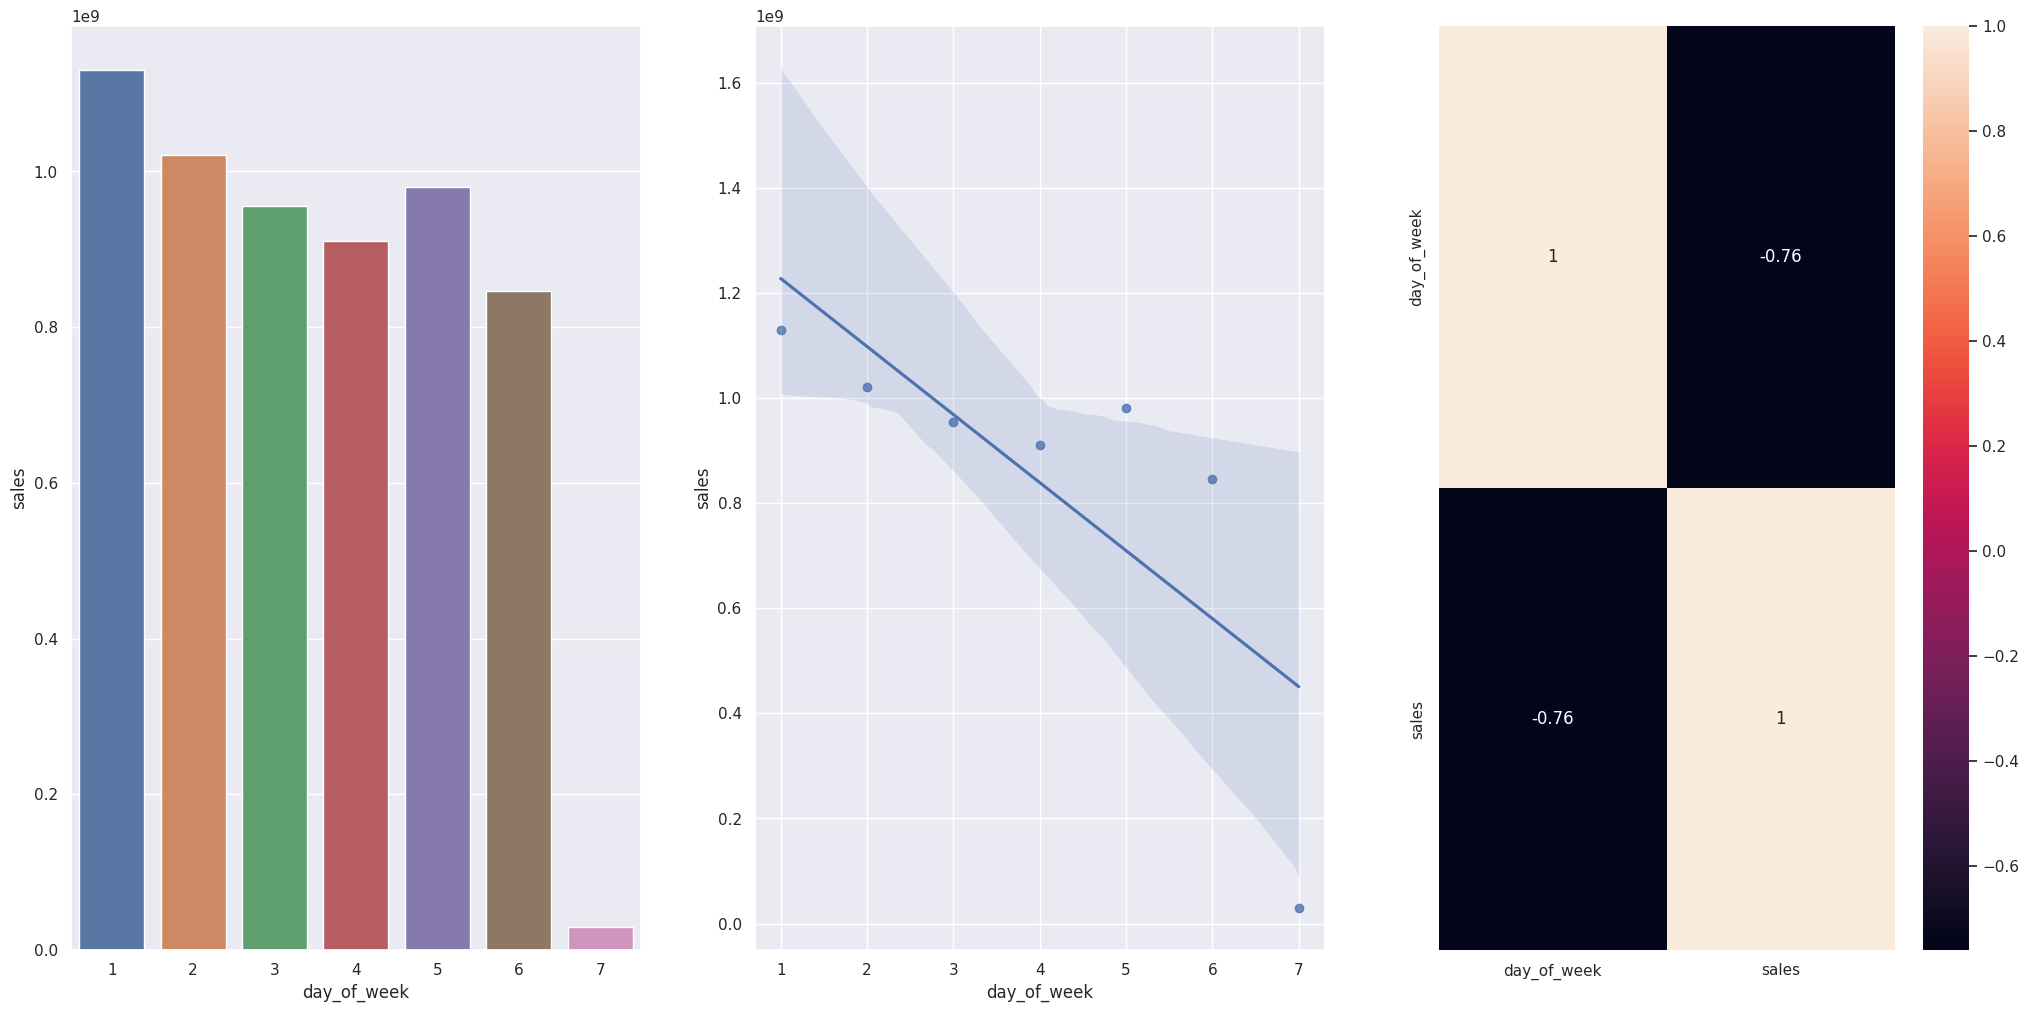

In [40]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H12. Lojas deveriam vender menos durante os feriados escolares.**
**VERDADEIRO** Exceto nos meses Julho e agosto, periodo de ferias. 

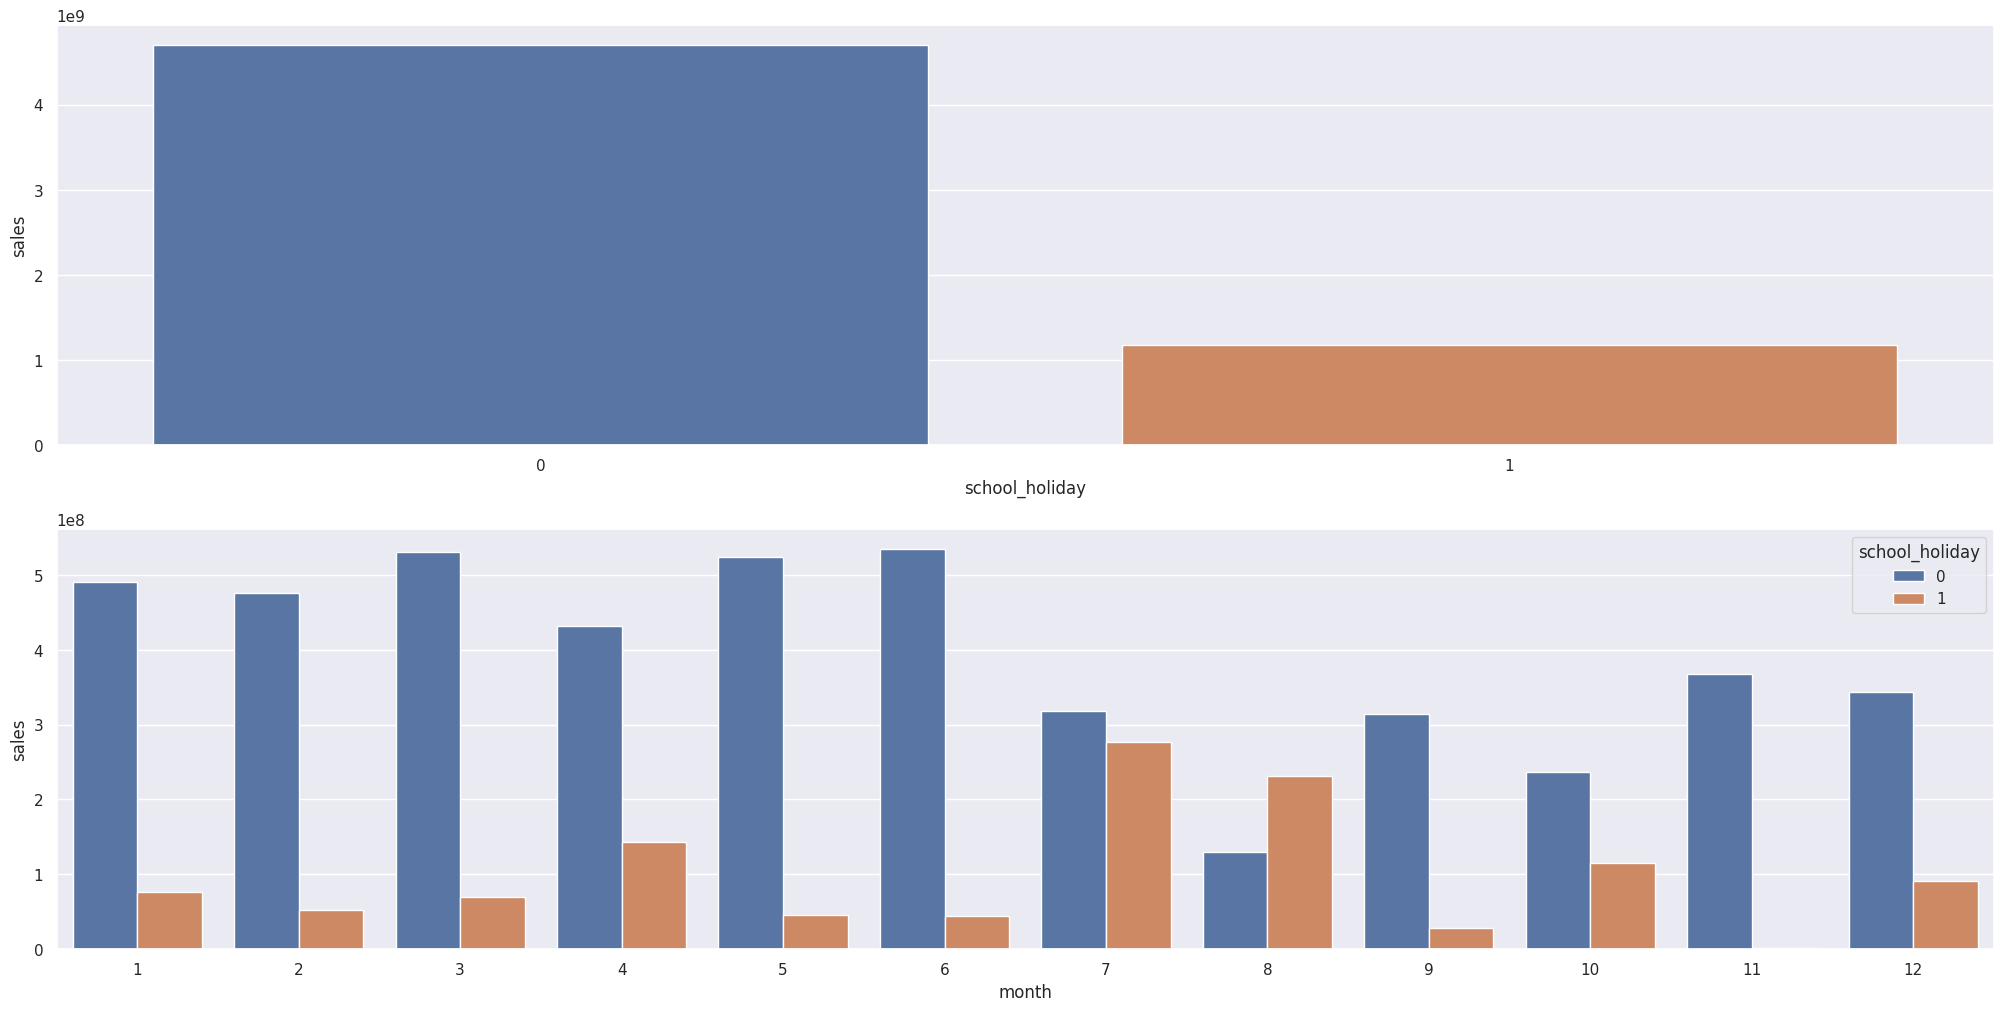

In [41]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

Observação:
* No grafico 1 temos que deixar claro que o total de feriado é menor que os dias regulares escolar, por isso o somatorio de vendas é maior.
* Grafico 2 - já mostra essa relação mes por mes. No mes 7 e 8 é periodo de ferias.

### 4.2.1 Resumo das Hipóteses

In [42]:
from tabulate import tabulate

In [43]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Media'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeiro', 'Alta'],
      ['H11', 'Verdadeiro', 'Alta'],
      ['H12', 'Verdadeiro', 'Alta']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Media
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Media
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeiro   Alta
H11          Verdadeiro   Alta
H12          Verdadeiro   Alta


## 4.3 Análise Multivariada

### 4.3.1 Numerical Atributes

<AxesSubplot: >

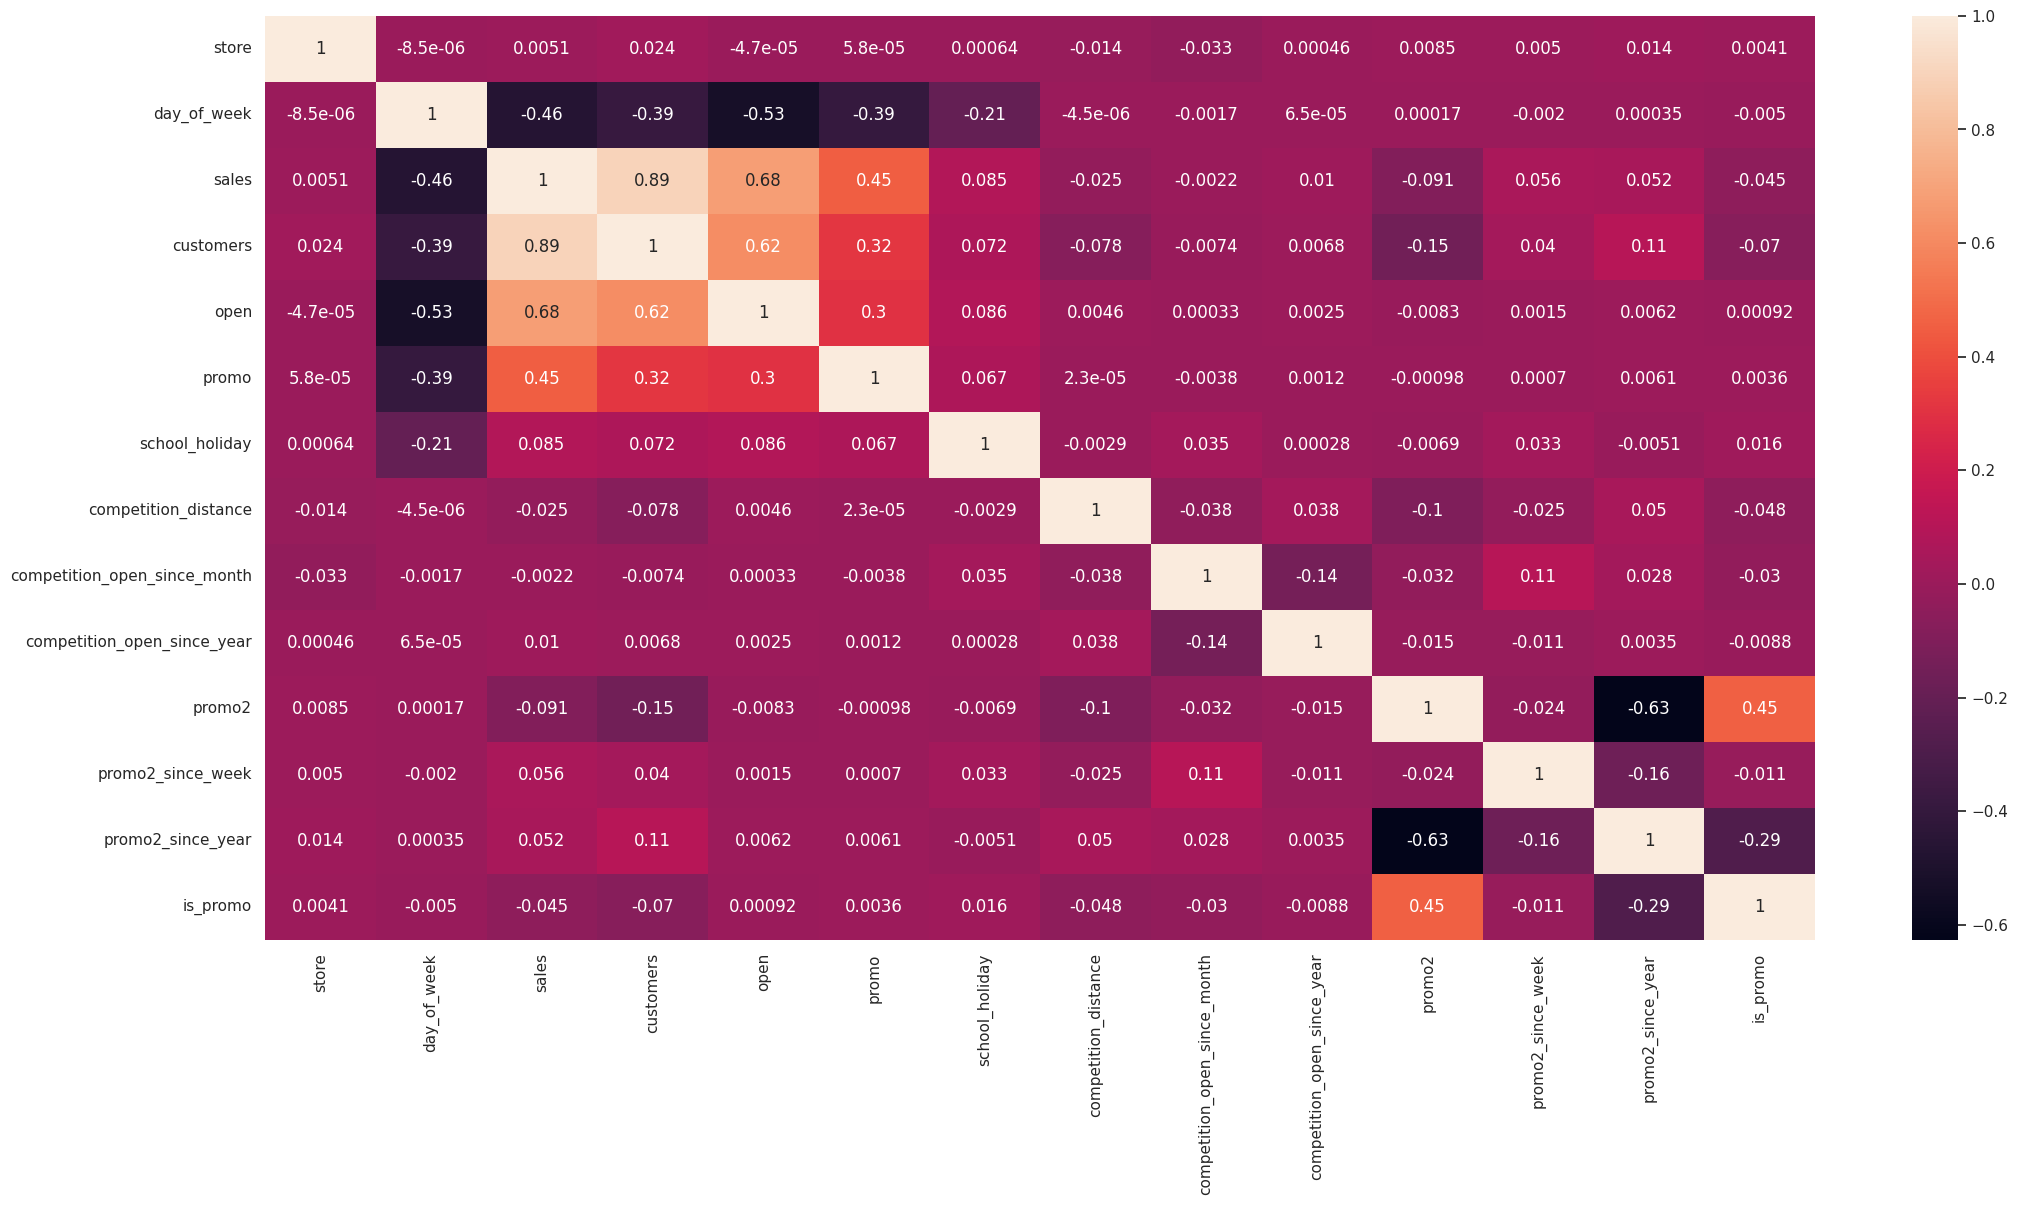

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Atributes

In [ ]:
# cramers
# o que é?
#  person é um teste estatistico para calcular correlaçãod e 2 variaveis numericas
# para fazer carrelação de variaveis categoricas se faz o v de cramers

<AxesSubplot: >

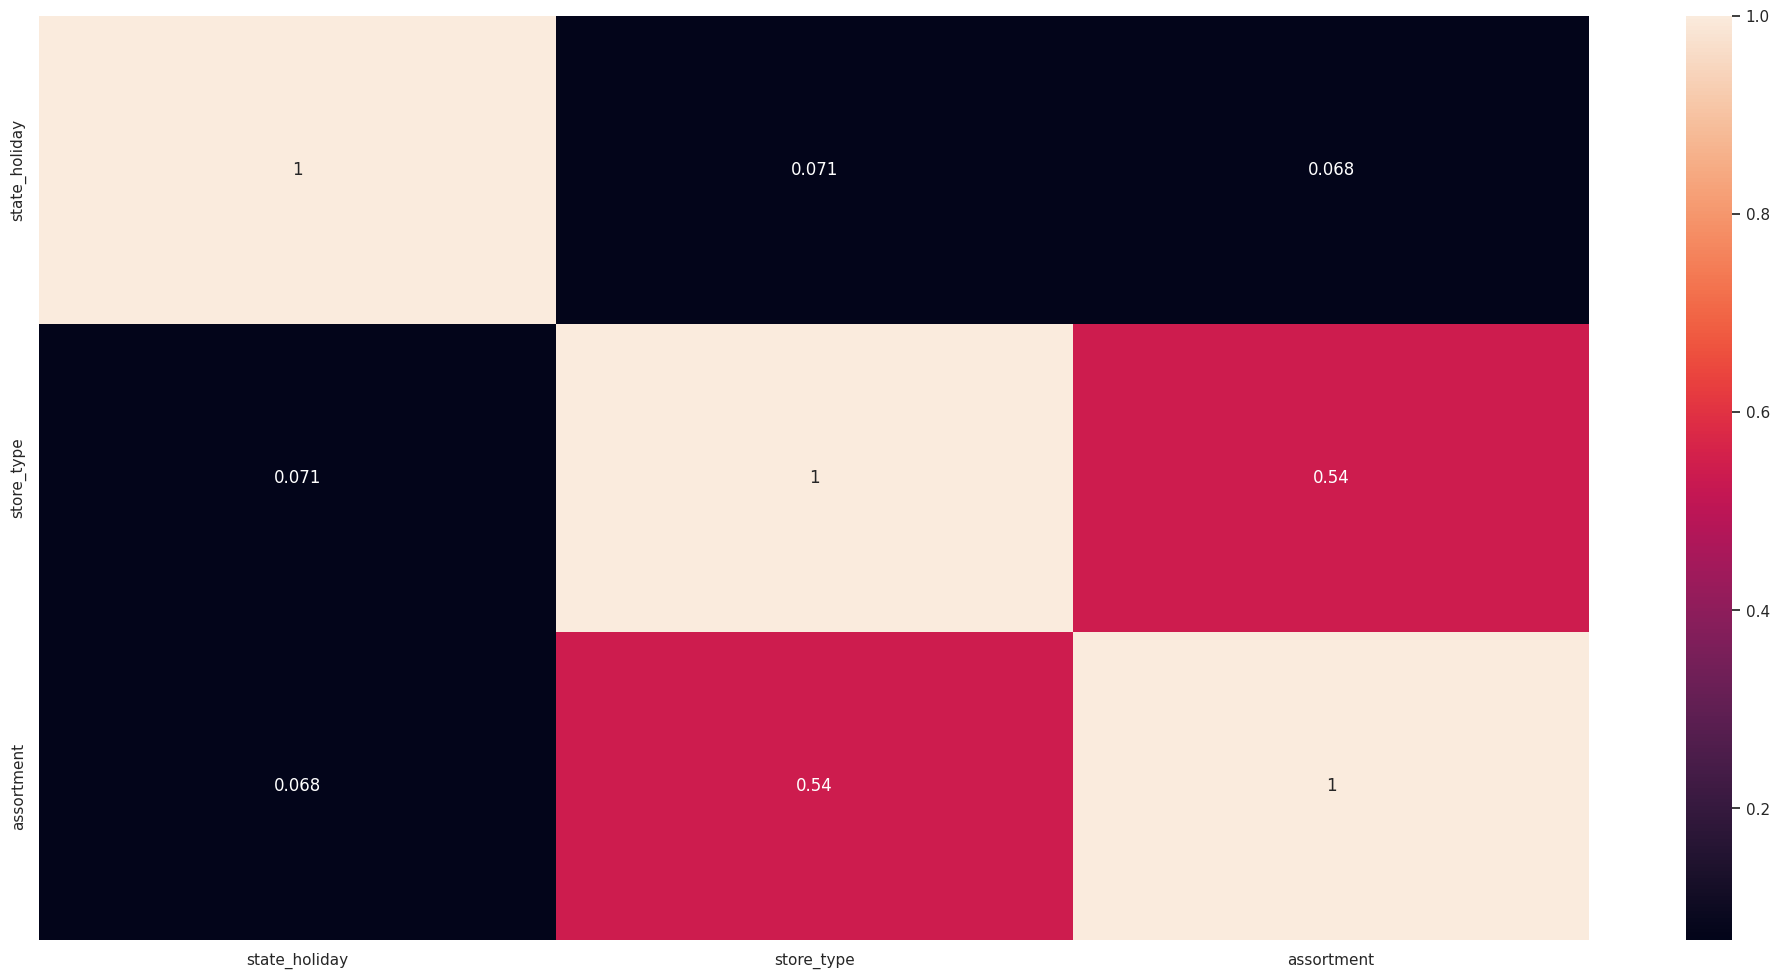

In [45]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])
              
# final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                 'store_type': [a4, a5, a6],
                 'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot= True)

# 5.0 - Data Preparation

In [ ]:
# Primeira motificação: mudar os dados categoricos para numericos
# Segunda modificação: em relação ao range, colocar todos na mesma escala.

In [55]:
df5 = df4.copy()

## 5.1 Normalização

In [ ]:
# buscar uma variavel com distribuição normal
# como vimos no Numerical Variable não há uma variavel com distribuição normal
# optamos em não normalizar nenhuma variavel, pois pode afetar o meu algoritmo forçando essa normalização. 

## 5.2 Rescaling

In [ ]:
# não muda a natureza da variavel
# min-max scaler é sensivel aos outliers
# robust scaler

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('/home/caroline/repos/DataScience_em_Producao/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open('/home/caroline/repos/DataScience_em_Producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('/home/caroline/repos/DataScience_em_Producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('/home/caroline/repos/DataScience_em_Producao/parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Enconding 

In [ ]:
# enconding - muda a variavel de categorica para numerica sem mudar o conteudo de unformação

In [ ]:
df5.head()

In [57]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/caroline/repos/DataScience_em_Producao/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [49]:
# transformação logaritma 
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2-3 Nature Transformation

In [50]:
## natureza ciclica - seno e cosseno
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52 )))

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()

## 6.1 Slit dataframe into training and test dataset

In [ ]:
# drop a coluna original que deriva a coluna_sin e coluna_cos
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
# pegar as ultimas 6 semanas e fazer como teste
# data antes das ultimas 6 semanas será os meus dados de treino

# para descobrir a data antes das 6 semanas
#df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 ) # resultado 2015-06-19

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))


# aqui, eu separei o meu dataset entre o de treino (data menor que 2015-06-19)
# e dataset de teste (data maior e igual que 2015-06-19)

## 6.2 Boruta as Feature Selector

OBSERVAÇÃO: Não foi possivel rodar essa parte do código no meu notebook (kernel dead), pois ocupou 100% da minha memória RAM. Como solução, rodei essa parte do código no google colab. Levou 2h30 para concluir. 

In [ ]:
# # training and test dataset for boruta
# x_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RadomForestRegressor
# rf = RandomForestRegressor( n_jobs= -1 ) # warm_start = True,

# # define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()


# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [ ]:
# cols_selected_boruta

## 6.3 Manual Feature Selection

In [ ]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Tiem Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [ ]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, how='left', on='store')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
# baseline_result

## 7.2 Linear Regression Model

In [ ]:
# # model
# lr = LinearRegression().fit(x_train, y_train)

# # prediction
# yhat_lr = lr.predict(x_test)

# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
# lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
# # model
# lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# # prediction
# yhat_lrr = lrr.predict(x_test)

# # performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Lasso - Cross Validation

In [ ]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
# lrr_result_cv

## 7.4 Random Forest Regressor

In [ ]:
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regression', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### 7.4.1 Random Forest Regressor- Cross Validation

In [ ]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regression', rf, verbose=True)
# rf_result_cv

## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regression', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XGBoots Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoots', model_xgb, verbose=True)
xgb_result_cv

## 7.5 Compare Model's Performance

In [ ]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2 Real Performace - Cross Validation

In [ ]:
# modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result.sort_values('RMSE CV')

Embora o Random tenha a medida melhor, vamos seguir com XGBoots por razão de estudo. 

# 8.0 Fine Tunning

**Implementação do Random Search do modelo XGBoost**

## 8.1 Random Search

In [ ]:
# param = {
#         'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15] }

# MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):

#     # choose values for parameters randomly

#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }

#     print( hp )


#     # model

#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytee=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'] )

#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )

#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2 Final Model

In [ ]:
# param_tuned = {
#           'n_estimators': 2500,
#           'eta': 0.01,
#           'max_depth': 9,
#           'subsample': 0.1,
#           'colsample_bytree': 0.7,
#           'min_child_weight': 8
# }

# # {'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}

In [ ]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'],
#                                     eta=param_tuned['eta'],
#                                     max_depth=param_tuned['max_depth'],
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
# xgb_result_tuned

# 9.0 Error translation and interpretation

In [ ]:
# X_test = df6[df6['date'] >= '2015-06-19']

df9 = X_test[cols_selected_boruta_full]

In [ ]:
# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
# sum of prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
# parametro sale com predictions
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0 : 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0 : 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values(by='MAPE',ascending=False ).head()

In [ ]:
# como observado, existe loja que tem a porcentagem de error maior que 50%, logo fica dificil obter a sua predição de vendas de 6 semanas.
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [ ]:
# mostrar a soma de todos os cenários de todas as lojas
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

## 9.1 Machine Learning Performance

In [ ]:
# calculando o erro
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
# análise do residuo
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES') # ao longo de 6 semanas mostra as vendas reais
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS') # ao longo de 6 semanas mostra as predições do modelo

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--') # baixo de 1 as predições são menores que as vendas reais

plt.subplot(2,2,3)
sns.histplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y ='error', data=df9)

# 10.0 Deploy Model to Production

In [ ]:
# Para salvar o modelo, que vai levar + de 1 dia.

pickle.dump(model_xgb_tuned, open('/home/caroline/repos/DataScience_em_Producao/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossamann Class

In [103]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(
                open('/home/caroline/repos/DataScience_em_Producao/parameter/competition_distance_scaler.pkl', 'rb'))
        
        self.competition_time_month_scaler = pickle.load(
                open('/home/caroline/repos/DataScience_em_Producao/parameter/competition_time_month_scaler.pkl', 'rb'))
        
        self.promo_time_week_scaler = pickle.load(
                open('/home/caroline/repos/DataScience_em_Producao/parameter/promo_time_week_scaler.pkl', 'rb'))
        
        self.year_scaler = pickle.load(
                open('/home/caroline/repos/DataScience_em_Producao/parameter/year_scaler.pkl', 'rb'))
        
        self.store_type_scaler = pickle.load(
                open('/home/caroline/repos/DataScience_em_Producao/parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename columns
        df1.columns = cols_new


        ## 1.3 Data Types

        # mudar o types da coluna date
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA

        #competition_distance - distancia em metros da loja competidora proxima
            # uma das formas de eliminar os NAs é preenchendo as linhas faltantes
            # utilizando a lógica de que talvez  NA é pq a loja competidora está bem distante
            # e para isso irei preencher um valor qualquer 200000.0 (maior q o valor maximo do meu dataframe) 

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month - mes/ano que a loja competidora foi aberta
            # quando é mais de uma coluna coloca axis=1

        df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month 
                                                       if math.isnan(x['competition_open_since_month']) else 
                                                       x['competition_open_since_month'], axis=1)

        #competition_open_since_year  
        df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year 
                                                       if math.isnan(x['competition_open_since_year']) else      
                                                       x['competition_open_since_year'], axis=1)                       
        #promo2_since_week
        df1['promo2_since_week']= df1.apply(lambda x: x['date'].week 
                                                       if math.isnan(x['promo2_since_week']) else      
                                                       x['promo2_since_week'], axis=1)  
        #promo2_since_year   
        df1['promo2_since_year']= df1.apply(lambda x: x['date'].year 
                                                       if math.isnan(x['promo2_since_year']) else      
                                                       x['promo2_since_year'], axis=1)
        #promo_interval - intervalos consecutivos quando a promo2 foi iniciada
        # dicionario indicando o numero dos meses
        month_map = {1: 'Jan',
                    2: 'Feb',
                    3: 'Mar',
                    4: 'Apr',
                    5: 'May',
                    6: 'Jun',
                    7: 'Jul',
                    8: 'Aug',
                    9: 'Sept',
                    10: 'Oct',
                    11: 'Nov',
                    12: 'Dec'}
        df1['promo_interval'] = df1['promo_interval'].fillna(0)
            # assumption: criadno uma coluna onde indica o mes da coluna date     
        df1['month_map'] = df1['date'].dt.month.map(month_map)

            # assumption: se o mes estiver presente na coluna 'promo_interval' logo tem promocao ativa naquela data 
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 
                                                                    1 if x['month_map'] in x['promo_interval'].split(',') 
                                                                    else 0, axis=1)


        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        
        return df1
    

    
    def feature_engineering(self, df2):

        ## extraindo novas features da coluna date
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        ## features de competition
        # competition since - juntas o mes - ano
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], 
                                                                         month= x['competition_open_since_month'] , day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        ## feature de promo
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        # transformando em datetime
        df2['promo_since'] = df2['promo_since'].apply(
                                lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        ## feature assortment
        df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 
                                                          'easter_holiday' if x == 'b' else 
                                                          'christmas' if x == 'c' else 'regular_day') 

        # 3.0 - Filtragem das Variáveis
        ## 3.1 - Filtragem das linhas

        # as restrições observadas para o negócio foram loja fechada e vendas nulas
        df2 = df2[(df2['open'] != 0)]

        ## 3.2 - Seleção

        # a coluna customers é uma restrição para o modelo, pois tem essa informação daqui 6 semanas
        # a não ser que eu faça outro modelo de previsão para calcular a coluna customers daqui 6 semanas.
        # então por isso, foi retirar essa coluna do meu dataset para fazer a predição de vendas daqui 6 semanas.
        cols_drop = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):

        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )


        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )
        

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )
        
        


        ## 5.3 Transformação

        ### 5.3.1 Enconding 

        # enconding - muda a variavel de categorica para numerica sem mudar o conteudo de unformação

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Enconding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        # assortment - Ordinal Enconding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ## natureza ciclica - seno e cosseno
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7 )))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12 )))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30 )))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30 )))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52 )))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52 )))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 
                                'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 
                                'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [104]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/caroline/repos/DataScience_em_Producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns= test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else: 
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.1 API Tester

In [77]:
import requests

In [99]:
# loading test dataset
df10 = pd.read_csv('/home/caroline/repos/DataScience_em_Producao/data/test.csv')

In [100]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24,12,22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)



In [101]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [108]:
# API call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data = data, headers = header)
print(f'Status code {r.status_code}')

Status code 200


In [110]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [111]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
                        d2.loc[i, 'store'],
                        d2.loc[i, 'prediction'] ) )

Store Number 12 will sell R$300,362.23 in the next 6 weeks
Store Number 22 will sell R$186,101.70 in the next 6 weeks
Store Number 24 will sell R$381,285.43 in the next 6 weeks
